In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import time

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *
from registration_utilities import *
from annotation_utilities import *
from metadata import *
from data_manager import *

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


Setting environment for AWS compute node


No vtk


# Global

In [67]:
stack_fixed = 'LM30'
# stack_fixed = 'LM40'
stack_moving = 'atlasV5'

In [68]:
# warp_setting = 20
warp_setting = 16
# Adding surr is essential.

In [69]:
registration_settings = read_csv(REGISTRATION_SETTINGS_CSV, header=0, index_col=0)
registration_settings

,upstream_warp_id,transform_type,terminate_thresh,grad_computation_sample_number,grid_search_sample_number,std_tx_um,std_ty_um,std_tz_um,std_theta_xy_degree,surround_weight,regularization_weight,comment
warp_id,,,,,,,,,,,,
1,None,affine,0.000010,100000.0,1000.0,2000,2000,2000,30,0,NaN,NaN
2,1,rigid,0.000010,100000.0,10000.0,100,100,100,30,0,NaN,NaN
4,1,rigid,0.000001,100000.0,10000.0,100,100,100,10,0,0.000001,NaN
5,1,rigid,0.000001,100000.0,10000.0,100,100,100,30,inverse,0.000000,NaN
6,1,affine,0.000010,100000.0,10000.0,100,100,100,30,-0.5,0.000000,NaN
7,None,rigid,0.000001,100000.0,1000.0,50,50,50,10,0,NaN,NaN
8,None,rigid,0.000001,100000.0,10000.0,200,200,200,30,inverse,0.000000,align mid-sagittal planes
9,8,rigid,0.000001,100000.0,10000.0,2000,2000,2000,30,NaN,NaN,global registration given mid-sagittal planes ...
18,8,affine,0.000001,100000.0,10000.0,200,200,200,30,NaN,NaN,global registration given mid-sagittal planes ...


In [70]:
warp_properties = registration_settings.loc[warp_setting]
print warp_properties

upstream_warp_setting = warp_properties['upstream_warp_id']
if upstream_warp_setting == 'None':
    upstream_warp_setting = None
transform_type = warp_properties['transform_type']
terminate_thresh = warp_properties['terminate_thresh']
grad_computation_sample_number = int(warp_properties['grad_computation_sample_number'])
grid_search_sample_number = warp_properties['grid_search_sample_number']
std_tx_um = warp_properties['std_tx_um']
std_ty_um = warp_properties['std_ty_um']
std_tz_um = warp_properties['std_tz_um']
std_tx = std_tx_um/(XY_PIXEL_DISTANCE_LOSSLESS*32)
std_ty = std_ty_um/(XY_PIXEL_DISTANCE_LOSSLESS*32)
std_tz = std_tz_um/(XY_PIXEL_DISTANCE_LOSSLESS*32)
std_theta_xy = np.deg2rad(warp_properties['std_theta_xy_degree'])
print std_tx, std_ty, std_tz, std_theta_xy

surround_weight = warp_properties['surround_weight']
if isinstance(surround_weight, float) or isinstance(surround_weight, int):
    surround_weight = float(surround_weight)
    include_surround = surround_weight != 0 and not np.isnan(surround_weight)
elif isinstance(surround_weight, str):
    surround_weight = str(surround_weight)
    # Setting surround_weight as inverse is very important. Using -1 often gives false peaks.
    include_surround = True

upstream_warp_id                                  None
transform_type                                  affine
terminate_thresh                                 1e-05
grad_computation_sample_number                  100000
grid_search_sample_number                         1000
std_tx_um                                         2000
std_ty_um                                         2000
std_tz_um                                         2000
std_theta_xy_degree                                 30
surround_weight                                inverse
regularization_weight                              NaN
comment                           global reg with surr
Name: 16, dtype: object
135.869565217 135.869565217 135.869565217 0.523598775598


In [71]:
MAX_ITER_NUM = 1000
HISTORY_LEN = 20
MAX_GRID_SEARCH_ITER_NUM = 30

lr1 = 10
lr2 = 0.1

In [72]:
volume_moving, structure_to_label_moving, label_to_structure_moving = \
DataManager.load_original_volume_all_known_structures(stack=stack_moving, sided=True, volume_type='score', 
                                                      include_surround=include_surround)
print volume_moving[1].shape

Prior structure/index map not found. Generating a new one.


rm -rf "/shared/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_outerContour.bp" && mkdir -p "/shared/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_outerContour.bp" "/shared/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_outerContour.bp"


File does not exist: /shared/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_outerContour.bp
Score volume for outerContour does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_outerContour.bp'


rm -rf "/shared/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_outerContour_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_outerContour_surround_200.bp" "/shared/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_outerContour_surround_200.bp"


File does not exist: /shared/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_outerContour_surround_200.bp
Score volume for outerContour_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_outerContour_surround_200.bp'


rm -rf "/shared/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_sp5.bp" && mkdir -p "/shared/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_sp5.bp" "/shared/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_sp5.bp"


File does not exist: /shared/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_sp5.bp
Score volume for sp5 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_sp5.bp'


rm -rf "/shared/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_sp5_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_sp5_surround_200.bp" "/shared/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_sp5_surround_200.bp"
(356, 427, 375)


File does not exist: /shared/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_sp5_surround_200.bp
Score volume for sp5_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_sp5_surround_200.bp'
Volume shape: (356, 427, 375)


In [73]:
volume_fixed, structure_to_label_fixed, label_to_structure_fixed = \
DataManager.load_original_volume_all_known_structures(stack=stack_fixed, sided=True, 
                                                      volume_type='annotationAsScore',
                                                     include_surround=include_surround)

print volume_fixed[1].shape

Prior structure/index map not found. Generating a new one.


rm -rf "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_10N_L.bp" && mkdir -p "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_10N_L.bp" "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_10N_L.bp"


File does not exist: /shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_10N_L.bp
Score volume for 10N_L does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_10N_L.bp'


rm -rf "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_10N_L_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_10N_L_surround_200.bp" "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_10N_L_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_10N_L_surround_200.bp
Score volume for 10N_L_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_10N_L_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_10N_R.bp" && mkdir -p "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_10N_R.bp" "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_10N_R.bp"


File does not exist: /shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_10N_R.bp
Score volume for 10N_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_10N_R.bp'


rm -rf "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_10N_R_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_10N_R_surround_200.bp" "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_10N_R_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_10N_R_surround_200.bp
Score volume for 10N_R_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_10N_R_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_12N.bp" && mkdir -p "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_12N.bp" "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_12N.bp"


File does not exist: /shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_12N.bp
Score volume for 12N does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_12N.bp'


rm -rf "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_12N_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_12N_surround_200.bp" "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_12N_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_12N_surround_200.bp
Score volume for 12N_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_12N_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_3N_R.bp" && mkdir -p "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_3N_R.bp" "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_3N_R.bp"


File does not exist: /shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_3N_R.bp
Score volume for 3N_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_3N_R.bp'


rm -rf "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_3N_R_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_3N_R_surround_200.bp" "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_3N_R_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_3N_R_surround_200.bp
Score volume for 3N_R_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_3N_R_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_4N_L.bp" && mkdir -p "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_4N_L.bp" "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_4N_L.bp"


File does not exist: /shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_4N_L.bp
Score volume for 4N_L does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_4N_L.bp'


rm -rf "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_4N_L_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_4N_L_surround_200.bp" "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_4N_L_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_4N_L_surround_200.bp
Score volume for 4N_L_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_4N_L_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_4N_R.bp" && mkdir -p "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_4N_R.bp" "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_4N_R.bp"


File does not exist: /shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_4N_R.bp
Score volume for 4N_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_4N_R.bp'


rm -rf "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_4N_R_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_4N_R_surround_200.bp" "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_4N_R_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_4N_R_surround_200.bp
Score volume for 4N_R_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_4N_R_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_5N_L.bp" && mkdir -p "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_5N_L.bp" "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_5N_L.bp"


File does not exist: /shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_5N_L.bp
Score volume for 5N_L does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_5N_L.bp'


rm -rf "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_5N_L_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_5N_L_surround_200.bp" "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_5N_L_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_5N_L_surround_200.bp
Score volume for 5N_L_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_5N_L_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_5N_R.bp" && mkdir -p "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_5N_R.bp" "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_5N_R.bp"


File does not exist: /shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_5N_R.bp
Score volume for 5N_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_5N_R.bp'


rm -rf "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_5N_R_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_5N_R_surround_200.bp" "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_5N_R_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_5N_R_surround_200.bp
Score volume for 5N_R_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_5N_R_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_6N_L.bp" && mkdir -p "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_6N_L.bp" "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_6N_L.bp"


File does not exist: /shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_6N_L.bp
Score volume for 6N_L does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_6N_L.bp'


rm -rf "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_6N_L_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_6N_L_surround_200.bp" "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_6N_L_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_6N_L_surround_200.bp
Score volume for 6N_L_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_6N_L_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_6N_R.bp" && mkdir -p "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_6N_R.bp" "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_6N_R.bp"


File does not exist: /shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_6N_R.bp
Score volume for 6N_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_6N_R.bp'


rm -rf "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_6N_R_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_6N_R_surround_200.bp" "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_6N_R_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_6N_R_surround_200.bp
Score volume for 6N_R_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_6N_R_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_7N_L.bp" && mkdir -p "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_7N_L.bp" "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_7N_L.bp"


File does not exist: /shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_7N_L.bp
Score volume for 7N_L does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_7N_L.bp'


rm -rf "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_7N_L_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_7N_L_surround_200.bp" "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_7N_L_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_7N_L_surround_200.bp
Score volume for 7N_L_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_7N_L_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_7N_R.bp" && mkdir -p "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_7N_R.bp" "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_7N_R.bp"


File does not exist: /shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_7N_R.bp
Score volume for 7N_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_7N_R.bp'


rm -rf "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_7N_R_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_7N_R_surround_200.bp" "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_7N_R_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_7N_R_surround_200.bp
Score volume for 7N_R_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_7N_R_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_7n_L.bp" && mkdir -p "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_7n_L.bp" "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_7n_L.bp"


File does not exist: /shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_7n_L.bp
Score volume for 7n_L does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_7n_L.bp'


rm -rf "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_7n_L_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_7n_L_surround_200.bp" "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_7n_L_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_7n_L_surround_200.bp
Score volume for 7n_L_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_7n_L_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_7n_R.bp" && mkdir -p "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_7n_R.bp" "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_7n_R.bp"


File does not exist: /shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_7n_R.bp
Score volume for 7n_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_7n_R.bp'


rm -rf "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_7n_R_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_7n_R_surround_200.bp" "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_7n_R_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_7n_R_surround_200.bp
Score volume for 7n_R_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_7n_R_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_AP.bp" && mkdir -p "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_AP.bp" "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_AP.bp"


File does not exist: /shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_AP.bp
Score volume for AP does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_AP.bp'


rm -rf "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_AP_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_AP_surround_200.bp" "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_AP_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_AP_surround_200.bp
Score volume for AP_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_AP_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_Amb_L.bp" && mkdir -p "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_Amb_L.bp" "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_Amb_L.bp"


File does not exist: /shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_Amb_L.bp
Score volume for Amb_L does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_Amb_L.bp'


rm -rf "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_Amb_L_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_Amb_L_surround_200.bp" "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_Amb_L_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_Amb_L_surround_200.bp
Score volume for Amb_L_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_Amb_L_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_Amb_R.bp" && mkdir -p "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_Amb_R.bp" "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_Amb_R.bp"


File does not exist: /shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_Amb_R.bp
Score volume for Amb_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_Amb_R.bp'


rm -rf "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_Amb_R_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_Amb_R_surround_200.bp" "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_Amb_R_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_Amb_R_surround_200.bp
Score volume for Amb_R_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_Amb_R_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_DC_L.bp" && mkdir -p "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_DC_L.bp" "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_DC_L.bp"


File does not exist: /shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_DC_L.bp
Score volume for DC_L does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_DC_L.bp'


rm -rf "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_DC_L_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_DC_L_surround_200.bp" "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_DC_L_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_DC_L_surround_200.bp
Score volume for DC_L_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_DC_L_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_DC_R.bp" && mkdir -p "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_DC_R.bp" "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_DC_R.bp"


File does not exist: /shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_DC_R.bp
Score volume for DC_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_DC_R.bp'


rm -rf "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_DC_R_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_DC_R_surround_200.bp" "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_DC_R_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_DC_R_surround_200.bp
Score volume for DC_R_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_DC_R_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_IC.bp" && mkdir -p "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_IC.bp" "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_IC.bp"


File does not exist: /shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_IC.bp
Score volume for IC does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_IC.bp'


rm -rf "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_IC_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_IC_surround_200.bp" "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_IC_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_IC_surround_200.bp
Score volume for IC_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_IC_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_LC_L.bp" && mkdir -p "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_LC_L.bp" "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_LC_L.bp"


File does not exist: /shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_LC_L.bp
Score volume for LC_L does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_LC_L.bp'


rm -rf "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_LC_L_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_LC_L_surround_200.bp" "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_LC_L_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_LC_L_surround_200.bp
Score volume for LC_L_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_LC_L_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_LC_R.bp" && mkdir -p "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_LC_R.bp" "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_LC_R.bp"


File does not exist: /shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_LC_R.bp
Score volume for LC_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_LC_R.bp'


rm -rf "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_LC_R_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_LC_R_surround_200.bp" "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_LC_R_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_LC_R_surround_200.bp
Score volume for LC_R_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_LC_R_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_LRt_L.bp" && mkdir -p "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_LRt_L.bp" "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_LRt_L.bp"


File does not exist: /shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_LRt_L.bp
Score volume for LRt_L does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_LRt_L.bp'


rm -rf "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_LRt_L_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_LRt_L_surround_200.bp" "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_LRt_L_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_LRt_L_surround_200.bp
Score volume for LRt_L_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_LRt_L_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_LRt_R.bp" && mkdir -p "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_LRt_R.bp" "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_LRt_R.bp"


File does not exist: /shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_LRt_R.bp
Score volume for LRt_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_LRt_R.bp'


rm -rf "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_LRt_R_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_LRt_R_surround_200.bp" "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_LRt_R_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_LRt_R_surround_200.bp
Score volume for LRt_R_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_LRt_R_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_PBG_L.bp" && mkdir -p "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_PBG_L.bp" "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_PBG_L.bp"


File does not exist: /shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_PBG_L.bp
Score volume for PBG_L does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_PBG_L.bp'


rm -rf "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_PBG_L_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_PBG_L_surround_200.bp" "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_PBG_L_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_PBG_L_surround_200.bp
Score volume for PBG_L_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_PBG_L_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_PBG_R.bp" && mkdir -p "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_PBG_R.bp" "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_PBG_R.bp"


File does not exist: /shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_PBG_R.bp
Score volume for PBG_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_PBG_R.bp'


rm -rf "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_PBG_R_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_PBG_R_surround_200.bp" "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_PBG_R_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_PBG_R_surround_200.bp
Score volume for PBG_R_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_PBG_R_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_Pn_L.bp" && mkdir -p "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_Pn_L.bp" "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_Pn_L.bp"


File does not exist: /shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_Pn_L.bp
Score volume for Pn_L does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_Pn_L.bp'


rm -rf "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_Pn_L_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_Pn_L_surround_200.bp" "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_Pn_L_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_Pn_L_surround_200.bp
Score volume for Pn_L_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_Pn_L_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_Pn_R.bp" && mkdir -p "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_Pn_R.bp" "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_Pn_R.bp"


File does not exist: /shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_Pn_R.bp
Score volume for Pn_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_Pn_R.bp'


rm -rf "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_Pn_R_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_Pn_R_surround_200.bp" "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_Pn_R_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_Pn_R_surround_200.bp
Score volume for Pn_R_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_Pn_R_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_RMC_R.bp" && mkdir -p "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_RMC_R.bp" "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_RMC_R.bp"


File does not exist: /shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_RMC_R.bp
Score volume for RMC_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_RMC_R.bp'


rm -rf "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_RMC_R_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_RMC_R_surround_200.bp" "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_RMC_R_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_RMC_R_surround_200.bp
Score volume for RMC_R_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_RMC_R_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_RtTg.bp" && mkdir -p "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_RtTg.bp" "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_RtTg.bp"


File does not exist: /shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_RtTg.bp
Score volume for RtTg does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_RtTg.bp'


rm -rf "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_RtTg_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_RtTg_surround_200.bp" "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_RtTg_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_RtTg_surround_200.bp
Score volume for RtTg_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_RtTg_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_SC.bp" && mkdir -p "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_SC.bp" "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_SC.bp"


File does not exist: /shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_SC.bp
Score volume for SC does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_SC.bp'


rm -rf "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_SC_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_SC_surround_200.bp" "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_SC_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_SC_surround_200.bp
Score volume for SC_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_SC_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_SNC_L.bp" && mkdir -p "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_SNC_L.bp" "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_SNC_L.bp"


File does not exist: /shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_SNC_L.bp
Score volume for SNC_L does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_SNC_L.bp'


rm -rf "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_SNC_L_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_SNC_L_surround_200.bp" "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_SNC_L_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_SNC_L_surround_200.bp
Score volume for SNC_L_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_SNC_L_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_SNC_R.bp" && mkdir -p "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_SNC_R.bp" "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_SNC_R.bp"


File does not exist: /shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_SNC_R.bp
Score volume for SNC_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_SNC_R.bp'


rm -rf "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_SNC_R_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_SNC_R_surround_200.bp" "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_SNC_R_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_SNC_R_surround_200.bp
Score volume for SNC_R_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_SNC_R_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_SNR_R.bp" && mkdir -p "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_SNR_R.bp" "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_SNR_R.bp"


File does not exist: /shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_SNR_R.bp
Score volume for SNR_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_SNR_R.bp'


rm -rf "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_SNR_R_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_SNR_R_surround_200.bp" "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_SNR_R_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_SNR_R_surround_200.bp
Score volume for SNR_R_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_SNR_R_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_Sp5C_L.bp" && mkdir -p "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_Sp5C_L.bp" "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_Sp5C_L.bp"


File does not exist: /shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_Sp5C_L.bp
Score volume for Sp5C_L does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_Sp5C_L.bp'


rm -rf "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_Sp5C_L_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_Sp5C_L_surround_200.bp" "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_Sp5C_L_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_Sp5C_L_surround_200.bp
Score volume for Sp5C_L_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_Sp5C_L_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_Sp5C_R.bp" && mkdir -p "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_Sp5C_R.bp" "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_Sp5C_R.bp"


File does not exist: /shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_Sp5C_R.bp
Score volume for Sp5C_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_Sp5C_R.bp'


rm -rf "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_Sp5C_R_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_Sp5C_R_surround_200.bp" "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_Sp5C_R_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_Sp5C_R_surround_200.bp
Score volume for Sp5C_R_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_Sp5C_R_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_Sp5I_L.bp" && mkdir -p "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_Sp5I_L.bp" "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_Sp5I_L.bp"


File does not exist: /shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_Sp5I_L.bp
Score volume for Sp5I_L does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_Sp5I_L.bp'


rm -rf "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_Sp5I_L_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_Sp5I_L_surround_200.bp" "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_Sp5I_L_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_Sp5I_L_surround_200.bp
Score volume for Sp5I_L_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_Sp5I_L_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_Sp5I_R.bp" && mkdir -p "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_Sp5I_R.bp" "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_Sp5I_R.bp"


File does not exist: /shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_Sp5I_R.bp
Score volume for Sp5I_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_Sp5I_R.bp'


rm -rf "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_Sp5I_R_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_Sp5I_R_surround_200.bp" "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_Sp5I_R_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_Sp5I_R_surround_200.bp
Score volume for Sp5I_R_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_Sp5I_R_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_Sp5O_L.bp" && mkdir -p "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_Sp5O_L.bp" "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_Sp5O_L.bp"


File does not exist: /shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_Sp5O_L.bp
Score volume for Sp5O_L does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_Sp5O_L.bp'


rm -rf "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_Sp5O_L_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_Sp5O_L_surround_200.bp" "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_Sp5O_L_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_Sp5O_L_surround_200.bp
Score volume for Sp5O_L_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_Sp5O_L_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_Sp5O_R.bp" && mkdir -p "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_Sp5O_R.bp" "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_Sp5O_R.bp"


File does not exist: /shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_Sp5O_R.bp
Score volume for Sp5O_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_Sp5O_R.bp'


rm -rf "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_Sp5O_R_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_Sp5O_R_surround_200.bp" "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_Sp5O_R_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_Sp5O_R_surround_200.bp
Score volume for Sp5O_R_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_Sp5O_R_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_Tz_L.bp" && mkdir -p "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_Tz_L.bp" "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_Tz_L.bp"


File does not exist: /shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_Tz_L.bp
Score volume for Tz_L does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_Tz_L.bp'


rm -rf "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_Tz_L_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_Tz_L_surround_200.bp" "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_Tz_L_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_Tz_L_surround_200.bp
Score volume for Tz_L_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_Tz_L_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_Tz_R.bp" && mkdir -p "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_Tz_R.bp" "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_Tz_R.bp"


File does not exist: /shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_Tz_R.bp
Score volume for Tz_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_Tz_R.bp'


rm -rf "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_Tz_R_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_Tz_R_surround_200.bp" "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_Tz_R_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_Tz_R_surround_200.bp
Score volume for Tz_R_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_Tz_R_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_VCA_L.bp" && mkdir -p "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_VCA_L.bp" "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_VCA_L.bp"


File does not exist: /shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_VCA_L.bp
Score volume for VCA_L does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_VCA_L.bp'


rm -rf "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_VCA_L_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_VCA_L_surround_200.bp" "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_VCA_L_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_VCA_L_surround_200.bp
Score volume for VCA_L_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_VCA_L_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_VCA_R.bp" && mkdir -p "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_VCA_R.bp" "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_VCA_R.bp"


File does not exist: /shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_VCA_R.bp
Score volume for VCA_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_VCA_R.bp'


rm -rf "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_VCA_R_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_VCA_R_surround_200.bp" "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_VCA_R_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_VCA_R_surround_200.bp
Score volume for VCA_R_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_VCA_R_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_VCP_L.bp" && mkdir -p "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_VCP_L.bp" "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_VCP_L.bp"


File does not exist: /shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_VCP_L.bp
Score volume for VCP_L does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_VCP_L.bp'


rm -rf "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_VCP_L_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_VCP_L_surround_200.bp" "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_VCP_L_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_VCP_L_surround_200.bp
Score volume for VCP_L_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_VCP_L_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_VCP_R.bp" && mkdir -p "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_VCP_R.bp" "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_VCP_R.bp"


File does not exist: /shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_VCP_R.bp
Score volume for VCP_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_VCP_R.bp'


rm -rf "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_VCP_R_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_VCP_R_surround_200.bp" "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_VCP_R_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_VCP_R_surround_200.bp
Score volume for VCP_R_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_VCP_R_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_VLL_L.bp" && mkdir -p "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_VLL_L.bp" "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_VLL_L.bp"


File does not exist: /shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_VLL_L.bp
Score volume for VLL_L does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_VLL_L.bp'


rm -rf "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_VLL_L_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_VLL_L_surround_200.bp" "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_VLL_L_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_VLL_L_surround_200.bp
Score volume for VLL_L_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_VLL_L_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_VLL_R.bp" && mkdir -p "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_VLL_R.bp" "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_VLL_R.bp"


File does not exist: /shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_VLL_R.bp
Score volume for VLL_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_VLL_R.bp'


rm -rf "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_VLL_R_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_VLL_R_surround_200.bp" "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_VLL_R_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_VLL_R_surround_200.bp
Score volume for VLL_R_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_VLL_R_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_outerContour.bp" && mkdir -p "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_outerContour.bp" "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_outerContour.bp"


File does not exist: /shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_outerContour.bp
Score volume for outerContour does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_outerContour.bp'


rm -rf "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_outerContour_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_outerContour_surround_200.bp" "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_outerContour_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_outerContour_surround_200.bp
Score volume for outerContour_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_outerContour_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_sp5.bp" && mkdir -p "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_sp5.bp" "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_sp5.bp"


File does not exist: /shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_sp5.bp
Score volume for sp5 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_sp5.bp'


rm -rf "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_sp5_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_sp5_surround_200.bp" "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_sp5_surround_200.bp"
(170, 143, 197)


File does not exist: /shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_sp5_surround_200.bp
Score volume for sp5_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volumes/LM30_down32_annotationAsScoreVolume_sp5_surround_200.bp'
Volume shape: (170, 143, 197)


In [74]:
structure_subset = all_known_structures_sided

In [75]:
if include_surround:
    structure_subset = structure_subset + [convert_to_surround_name(s, margin=200) for s in structure_subset]

In [76]:
label_mapping_m2f = {label_m: structure_to_label_fixed[name_m] 
                     for label_m, name_m in label_to_structure_moving.iteritems()
                     if name_m in structure_subset and name_m in structure_to_label_fixed}

In [77]:
positive_weight = 'size'
# positive_weight = 'inverse'

In [78]:
cutoff = .5 # Structure size is defined as the number of voxels whose value is above this cutoff probability.
pool = Pool(NUM_CORES)
volume_moving_structure_sizes = dict(zip(volume_moving.keys(), 
                                         pool.map(lambda l: np.count_nonzero(volume_moving[l] > cutoff), 
                                                  volume_moving.keys())))
pool.close()
pool.join()

In [79]:
label_weights_m = {}

for label_m in label_mapping_m2f.iterkeys():
    name_m = label_to_structure_moving[label_m]
    if not is_surround_label(name_m):
        if positive_weight == 'size':
            label_weights_m[label_m] = 1.
        elif positive_weight == 'inverse':
            p = np.percentile(volume_moving_structure_sizes.values(), 50)
            label_weights_m[label_m] =  np.minimum(p / volume_moving_structure_sizes[label_m], 1.)
        else:
            sys.stderr.write("positive_weight %s is not recognized. Using the default.\n" % positive_weight)
            
for label_m in label_mapping_m2f.iterkeys():
    name_m = label_to_structure_moving[label_m]
    if is_surround_label(name_m):
        label_ns = structure_to_label_moving[convert_to_nonsurround_name(name_m)]
        if surround_weight == 'inverse':
#             label_weights_m[label_m] = - label_weights_m[label_ns] * volume_moving_structure_sizes[label_ns]/float(volume_moving_structure_sizes[label_m])
            label_weights_m[label_m] = label_weights_m[label_ns] * volume_moving_structure_sizes[label_ns]/float(volume_moving_structure_sizes[label_m])
        elif isinstance(surround_weight, int) or isinstance(surround_weight, float):
            label_weights_m[label_m] = surround_weight
        else:
            sys.stderr.write("surround_weight %s is not recognized. Using the default.\n" % surround_weight)

In [80]:
label_weights_m

{7: 1.0,
 8: 0.08578068878090006,
 59: 1.0,
 60: 0.15379052789032086,
 71: 1.0,
 72: 0.40870655618253604}

In [81]:
aligner = Aligner4(volume_fixed, volume_moving, labelIndexMap_m2f=label_mapping_m2f)

Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


In [82]:
# aligner.set_centroid(centroid_m='origin', centroid_f='origin')
# aligner.set_centroid(centroid_m='volume_centroid', centroid_f='centroid_m')
# aligner.set_centroid(centroid_m='volume_centroid', centroid_f='volume_centroid')
aligner.set_centroid(centroid_m='structure_centroid', centroid_f='structure_centroid', indices_m=[structure_to_label_moving['SNR_L']])

centroid_m: [  50.43135167  207.82499502   91.38163608], centroid_f: [  68.79608517  101.98764769   61.5795571 ]


In [83]:
aligner.set_label_weights(label_weights=label_weights_m)

In [84]:
gradient_filepath_map_f = \
{ind_f: DataManager.get_volume_gradient_filepath_template(\
                                                          stack=stack_fixed, 
                                                          structure=label_to_structure_fixed[ind_f],
                                                         volume_type='annotationAsScore')
 for ind_m, ind_f in label_mapping_m2f.iteritems()}

In [85]:
gradient_filepath_map_f

{1: '/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volume_gradients/LM30_down32_annotationAsScoreVolume_3N_L_%(suffix)s.bp',
 2: '/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volume_gradients/LM30_down32_annotationAsScoreVolume_3N_L_surround_200_%(suffix)s.bp',
 3: '/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volume_gradients/LM30_down32_annotationAsScoreVolume_RMC_L_%(suffix)s.bp',
 4: '/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volume_gradients/LM30_down32_annotationAsScoreVolume_RMC_L_surround_200_%(suffix)s.bp',
 5: '/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volume_gradients/LM30_down32_annotationAsScoreVolume_SNR_L_%(suffix)s.bp',
 6: '/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volume_gradients/LM30_down32_annotationAsScoreVolume_SNR_L_surround_200_%(suffix)s.bp'}

In [86]:
aligner.load_gradient(gradient_filepath_map_f=gradient_filepath_map_f) # 120s-170 = 2 mins; all 28, 220s

indices_f: set([1, 2, 3, 4, 5, 6])
load gradient 1: 0.091051 seconds
load gradient 2: 0.089477 seconds
load gradient 3: 0.088842 seconds
load gradient 4: 0.092047 seconds
load gradient 5: 0.091116 seconds
load gradient 6: 0.094369 seconds
overall: 0.547547 seconds


In [87]:
# Tuning learning rate:
# lr1=10., if lucky converges much faster than lr1=1., but sometimes stuck in local maxima
# If lr1=1., grad_computation_sample_number=1e5 is sufficient.

trial_num = 1

T_all_trials = []
scores_all_trials = []
traj_all_trials = []

for _ in range(trial_num):

    try:
        T, scores = aligner.optimize(tf_type=transform_type, 
                                     max_iter_num=MAX_ITER_NUM,
#                                      max_iter_num=300,
                                     history_len=HISTORY_LEN, 
                                     terminate_thresh_rot=.002,
                                     terminate_thresh_trans=.2,
                                     grad_computation_sample_number=grad_computation_sample_number,
                                     lr1=lr1, lr2=lr2,
#                                     init_T=grid_search_T, 
#                                      affine_scaling_limits=(.9, 1.2)
                                    )
        T_all_trials.append(T)
        scores_all_trials.append(scores)
        traj_all_trials.append(aligner.Ts)
        
    except Exception as e:
        sys.stderr.write('%s\n' % e)


iteration 0
7: use 17796 samples out of 17796 valid
sample: 0.02 s
8: use 61538 samples out of 61538 valid
sample: 0.07 s
71: use 100000 samples out of 426325 valid
sample: 0.13 s
72: use 100000 samples out of 354153 valid
sample: 0.13 s
59: use 100000 samples out of 103620 valid
sample: 0.12 s
60: use 100000 samples out of 100972 valid
sample: 0.12 s
in T: 0.00 0.00 0.00, out T: -10.00 -10.00 10.00
step: 0.83 seconds
current score: 0.390175
new_T: [-10. -10. 10.]
det: 1.10

iteration 1
7: use 17796 samples out of 17796 valid
sample: 0.02 s
8: use 55516 samples out of 55516 valid
sample: 0.07 s
71: use 100000 samples out of 426325 valid
sample: 0.14 s
72: use 100000 samples out of 354153 valid
sample: 0.13 s
59: use 100000 samples out of 103620 valid
sample: 0.12 s
60: use 100000 samples out of 100972 valid
sample: 0.12 s
in T: -10.00 -10.00 10.00, out T: -0.26 -1.65 0.09
step: 0.87 seconds
current score: 0.267926
new_T: [-0.25980312 -1.65096091  0.08763567]
det: 0.94

iteration 2
7: 

sample: 0.15 s
59: use 100000 samples out of 103620 valid
sample: 0.13 s
60: use 100000 samples out of 100972 valid
sample: 0.13 s
in T: -1.42 -2.91 -0.02, out T: -0.03 -1.79 -1.99
step: 0.93 seconds
current score: 0.392649
new_T: [-0.02854077 -1.78861534 -1.99460383]
det: 1.23

iteration 17
7: use 17796 samples out of 17796 valid
sample: 0.02 s
8: use 60757 samples out of 60757 valid
sample: 0.08 s
71: use 100000 samples out of 426325 valid
sample: 0.16 s
72: use 100000 samples out of 354153 valid
sample: 0.15 s
59: use 100000 samples out of 103620 valid
sample: 0.13 s
60: use 100000 samples out of 100972 valid
sample: 0.13 s
in T: -0.03 -1.79 -1.99, out T: -1.19 -2.88 -0.24
step: 0.93 seconds
current score: 0.390836
new_T: [-1.19407668 -2.87563633 -0.23813306]
det: 1.25

iteration 18
7: use 17796 samples out of 17796 valid
sample: 0.02 s
8: use 61522 samples out of 61522 valid
sample: 0.08 s
71: use 100000 samples out of 426325 valid
sample: 0.16 s
72: use 100000 samples out of 35415

71: use 100000 samples out of 426325 valid
sample: 0.16 s
72: use 100000 samples out of 354153 valid
sample: 0.15 s
59: use 100000 samples out of 103620 valid
sample: 0.13 s
60: use 100000 samples out of 100972 valid
sample: 0.13 s
in T: -0.00 -2.64 -1.37, out T: -0.28 -2.81 -0.92
step: 0.94 seconds
current score: 0.389086
new_T: [-0.27888948 -2.80994129 -0.92076925]
det: 1.26

iteration 34
7: use 17796 samples out of 17796 valid
sample: 0.02 s
8: use 61321 samples out of 61321 valid
sample: 0.08 s
71: use 100000 samples out of 426325 valid
sample: 0.16 s
72: use 100000 samples out of 354153 valid
sample: 0.17 s
59: use 100000 samples out of 103620 valid
sample: 0.14 s
60: use 100000 samples out of 100972 valid
sample: 0.13 s
in T: -0.28 -2.81 -0.92, out T: -0.10 -2.70 -1.39
step: 0.95 seconds
current score: 0.389666
new_T: [-0.1031766  -2.6953873  -1.38615911]
det: 1.26

iteration 35
7: use 17796 samples out of 17796 valid
sample: 0.02 s
8: use 61106 samples out of 61106 valid
sample:

sample: 0.14 s
in T: -0.01 -2.66 -1.26, out T: -0.21 -2.79 -0.97
step: 0.93 seconds
current score: 0.388796
new_T: [-0.21083497 -2.78950156 -0.97196968]
det: 1.27

iteration 50
7: use 17796 samples out of 17796 valid
sample: 0.02 s
8: use 61197 samples out of 61197 valid
sample: 0.08 s
71: use 100000 samples out of 426325 valid
sample: 0.16 s
72: use 100000 samples out of 354153 valid
sample: 0.15 s
59: use 100000 samples out of 103620 valid
sample: 0.13 s
60: use 100000 samples out of 100972 valid
sample: 0.13 s
in T: -0.21 -2.79 -0.97, out T: -0.03 -2.61 -1.33
step: 0.94 seconds
current score: 0.388669
new_T: [-0.02775804 -2.60684437 -1.33259887]
det: 1.27

iteration 51
7: use 17796 samples out of 17796 valid
sample: 0.02 s
8: use 61056 samples out of 61056 valid
sample: 0.08 s
71: use 100000 samples out of 426325 valid
sample: 0.16 s
72: use 100000 samples out of 354153 valid
sample: 0.16 s
59: use 100000 samples out of 103620 valid
sample: 0.13 s
60: use 100000 samples out of 10097

sample: 0.02 s
8: use 61188 samples out of 61188 valid
sample: 0.08 s
71: use 100000 samples out of 426325 valid
sample: 0.16 s
72: use 100000 samples out of 354153 valid
sample: 0.17 s
59: use 100000 samples out of 103620 valid
sample: 0.14 s
60: use 100000 samples out of 100972 valid
sample: 0.13 s
in T: -0.11 -2.80 -1.02, out T: 0.06 -2.64 -1.19
step: 0.96 seconds
current score: 0.388209
new_T: [ 0.05795826 -2.63584309 -1.19204579]
det: 1.27

iteration 67
7: use 17796 samples out of 17796 valid
sample: 0.02 s
8: use 61058 samples out of 61058 valid
sample: 0.08 s
71: use 100000 samples out of 426325 valid
sample: 0.16 s
72: use 100000 samples out of 354153 valid
sample: 0.16 s
59: use 100000 samples out of 103620 valid
sample: 0.13 s
60: use 100000 samples out of 100972 valid
sample: 0.13 s
in T: 0.06 -2.64 -1.19, out T: -0.10 -2.80 -1.04
step: 0.94 seconds
current score: 0.388365
new_T: [-0.09845172 -2.80132887 -1.04228516]
det: 1.27

iteration 68
7: use 17796 samples out of 17796 

sample: 0.16 s
59: use 100000 samples out of 103620 valid
sample: 0.13 s
60: use 100000 samples out of 100972 valid
sample: 0.13 s
in T: -0.17 -2.77 -1.00, out T: 0.07 -2.62 -1.18
step: 0.94 seconds
current score: 0.388607
new_T: [ 0.06582908 -2.62399    -1.17977214]
det: 1.27

iteration 83
7: use 17796 samples out of 17796 valid
sample: 0.02 s
8: use 61027 samples out of 61027 valid
sample: 0.08 s
71: use 100000 samples out of 426325 valid
sample: 0.18 s
72: use 100000 samples out of 354153 valid
sample: 0.16 s
59: use 100000 samples out of 103620 valid
sample: 0.13 s
60: use 100000 samples out of 100972 valid
sample: 0.13 s
in T: 0.07 -2.62 -1.18, out T: -0.16 -2.78 -1.03
step: 0.96 seconds
current score: 0.388467
new_T: [-0.15776699 -2.77623721 -1.03049247]
det: 1.28

iteration 84
7: use 17796 samples out of 17796 valid
sample: 0.02 s
8: use 61214 samples out of 61214 valid
sample: 0.08 s
71: use 100000 samples out of 426325 valid
sample: 0.16 s
72: use 100000 samples out of 354153 

sample: 0.08 s
71: use 100000 samples out of 426325 valid
sample: 0.16 s
72: use 100000 samples out of 354153 valid
sample: 0.15 s
59: use 100000 samples out of 103620 valid
sample: 0.14 s
60: use 100000 samples out of 100972 valid
sample: 0.13 s
in T: 0.12 -2.55 -1.13, out T: -0.04 -2.77 -1.02
step: 0.95 seconds
current score: 0.388490
new_T: [-0.04307593 -2.7655393  -1.01559235]
det: 1.27

iteration 100
7: use 17796 samples out of 17796 valid
sample: 0.02 s
8: use 61206 samples out of 61206 valid
sample: 0.08 s
71: use 100000 samples out of 426325 valid
sample: 0.16 s
72: use 100000 samples out of 354153 valid
sample: 0.15 s
59: use 100000 samples out of 103620 valid
sample: 0.13 s
60: use 100000 samples out of 100972 valid
sample: 0.13 s
in T: -0.04 -2.77 -1.02, out T: 0.14 -2.53 -1.14
step: 0.93 seconds
current score: 0.388837
new_T: [ 0.14324558 -2.52686847 -1.13513614]
det: 1.27

iteration 101
7: use 17796 samples out of 17796 valid
sample: 0.02 s
8: use 61045 samples out of 6104

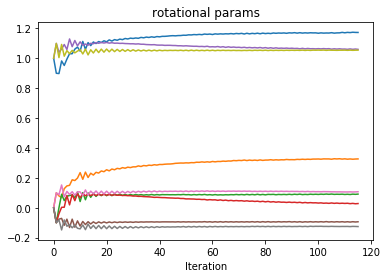

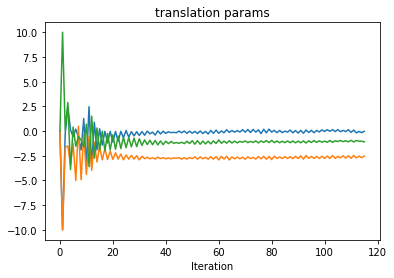

In [88]:
Ts = np.array(aligner.Ts)

plt.plot(Ts[:, [0,1,2,4,5,6,8,9,10]]);
plt.title('rotational params');
plt.xlabel('Iteration');
plt.show();

plt.plot(Ts[:, [3,7,11]]);
plt.title('translation params');
plt.xlabel('Iteration');
plt.show();

Best trial: 0
0.430337796685 0.388265972593
[[  8.98201169e-01   7.90704387e-02  -1.05526741e-04  -2.59803119e-01]
 [ -3.98833502e-02   1.04017624e+00  -7.64800398e-02  -1.65096091e+00]
 [  8.71686310e-02  -8.10897615e-02   1.00477015e+00   8.76356689e-02]]


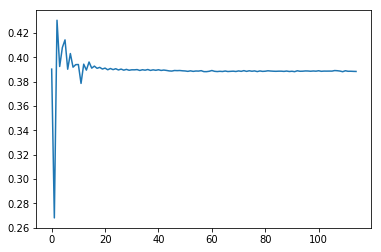

In [89]:
best_trial = np.argsort([np.max(scores) for scores in scores_all_trials])[-1]
# best_trial = 1
T = T_all_trials[best_trial]
scores = scores_all_trials[best_trial]
print 'Best trial:', best_trial
print max(scores), scores[-1]

print T.reshape((3,4))
plt.figure();
plt.plot(scores);
plt.show();

In [90]:
# global_params, centroid_m, centroid_f, xdim_m, ydim_m, zdim_m, xdim_f, ydim_f, zdim_f = \
# (affine_components_to_vector(-9.77304587,  48.73149657,  -2.80149108,  -0.16628751), 
#   aligner.centroid_m, aligner.centroid_f,
#   aligner.xdim_m, aligner.ydim_m, aligner.zdim_m, 
#   aligner.xdim_f, aligner.ydim_f, aligner.zdim_f)

# global_params, centroid_m, centroid_f, xdim_m, ydim_m, zdim_m, xdim_f, ydim_f, zdim_f = \
# (np.array([1,0,0,130,0,1,0,-70,0,0,1,0]), 
#   aligner.centroid_m, aligner.centroid_f,
#   aligner.xdim_m, aligner.ydim_m, aligner.zdim_m, 
#   aligner.xdim_f, aligner.ydim_f, aligner.zdim_f)

# global_params, centroid_m, centroid_f, xdim_m, ydim_m, zdim_m, xdim_f, ydim_f, zdim_f = \
# (grid_search_T, 
#   aligner.centroid_m, aligner.centroid_f,
#   aligner.xdim_m, aligner.ydim_m, aligner.zdim_m, 
#   aligner.xdim_f, aligner.ydim_f, aligner.zdim_f)

global_params, centroid_m, centroid_f, xdim_m, ydim_m, zdim_m, xdim_f, ydim_f, zdim_f = \
(T, 
  aligner.centroid_m, aligner.centroid_f,
  aligner.xdim_m, aligner.ydim_m, aligner.zdim_m, 
  aligner.xdim_f, aligner.ydim_f, aligner.zdim_f)

# global_params, centroid_m, centroid_f, xdim_m, ydim_m, zdim_m, xdim_f, ydim_f, zdim_f = \
# (np.array([1,0,0,0,0,1,0,0,0,0,1,0]), 
#   aligner.centroid_m, aligner.centroid_f,
#   aligner.xdim_m, aligner.ydim_m, aligner.zdim_m, 
#   aligner.xdim_f, aligner.ydim_f, aligner.zdim_f)

In [91]:
structure = '3N_L'

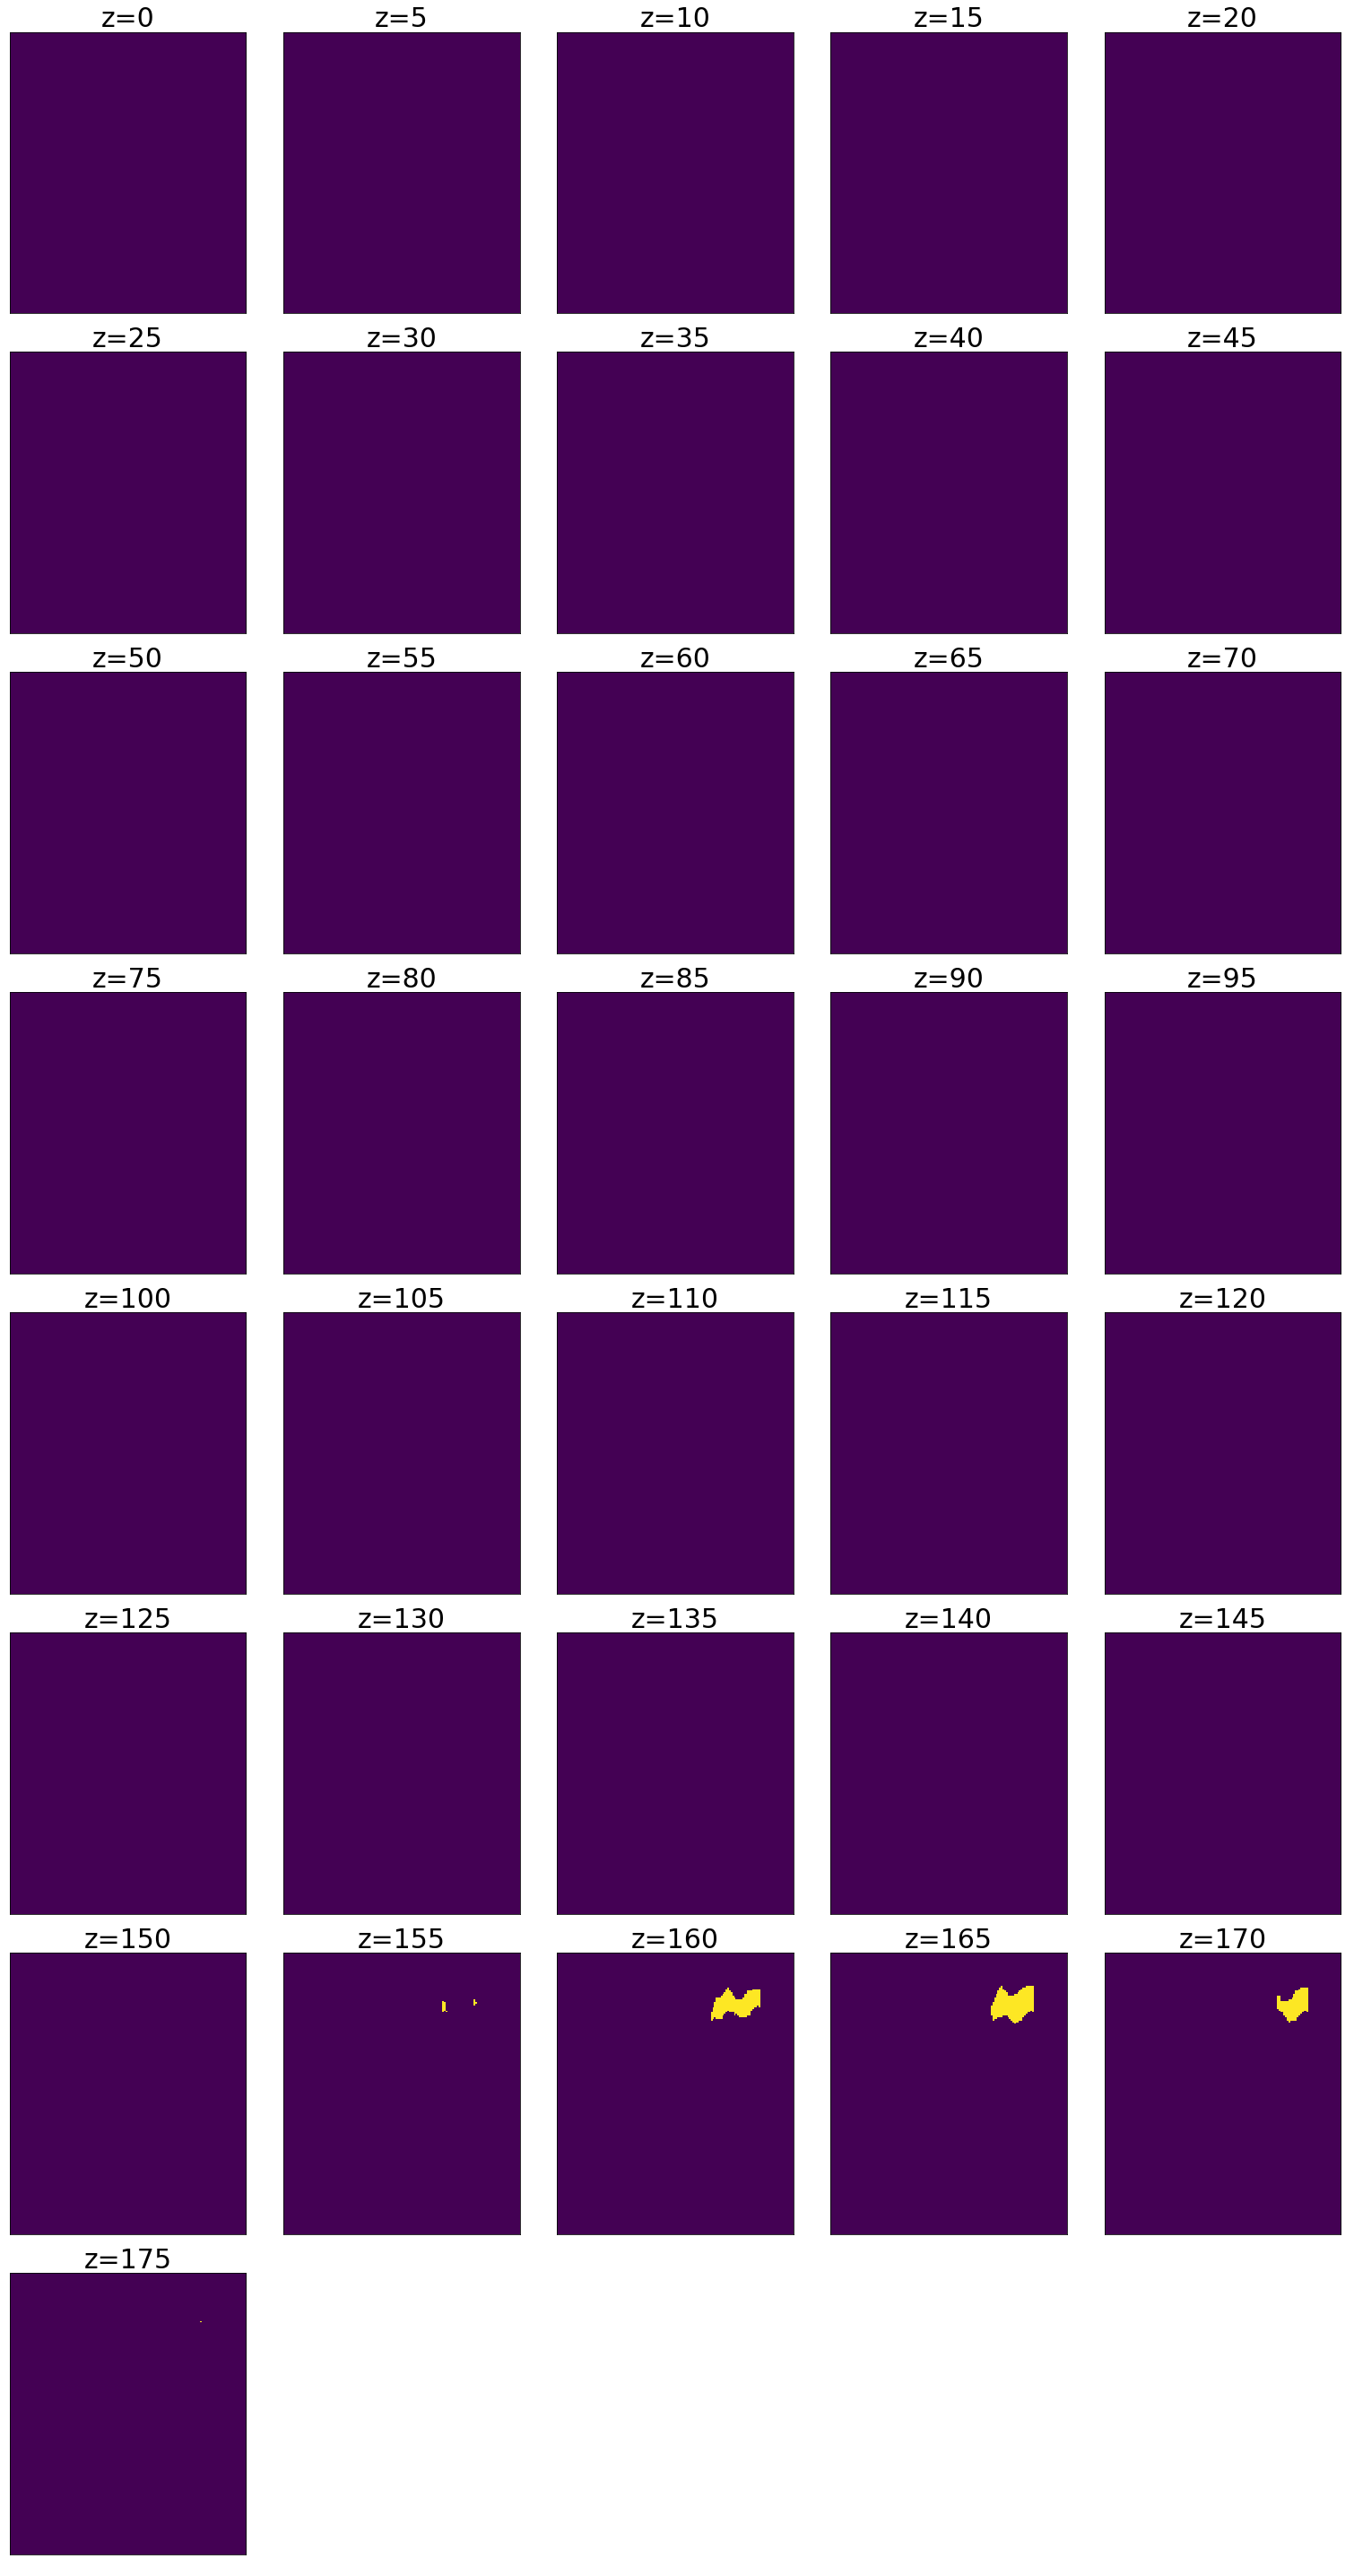

In [92]:
display_volume_sections(volume_fixed[structure_to_label_fixed[structure]], start_level=0)

In [93]:
# vol_m = DataManager.load_original_volume(stack=stack_moving, structure=structure, downscale=32)

vol_m = volume_moving[structure_to_label_moving[structure]]

volume_m_alignedTo_f, volume_m_alignedTo_f_bbox = \
transform_volume_v2(vol=vol_m, tf_params=global_params, centroid_m=centroid_m, centroid_f=centroid_f)

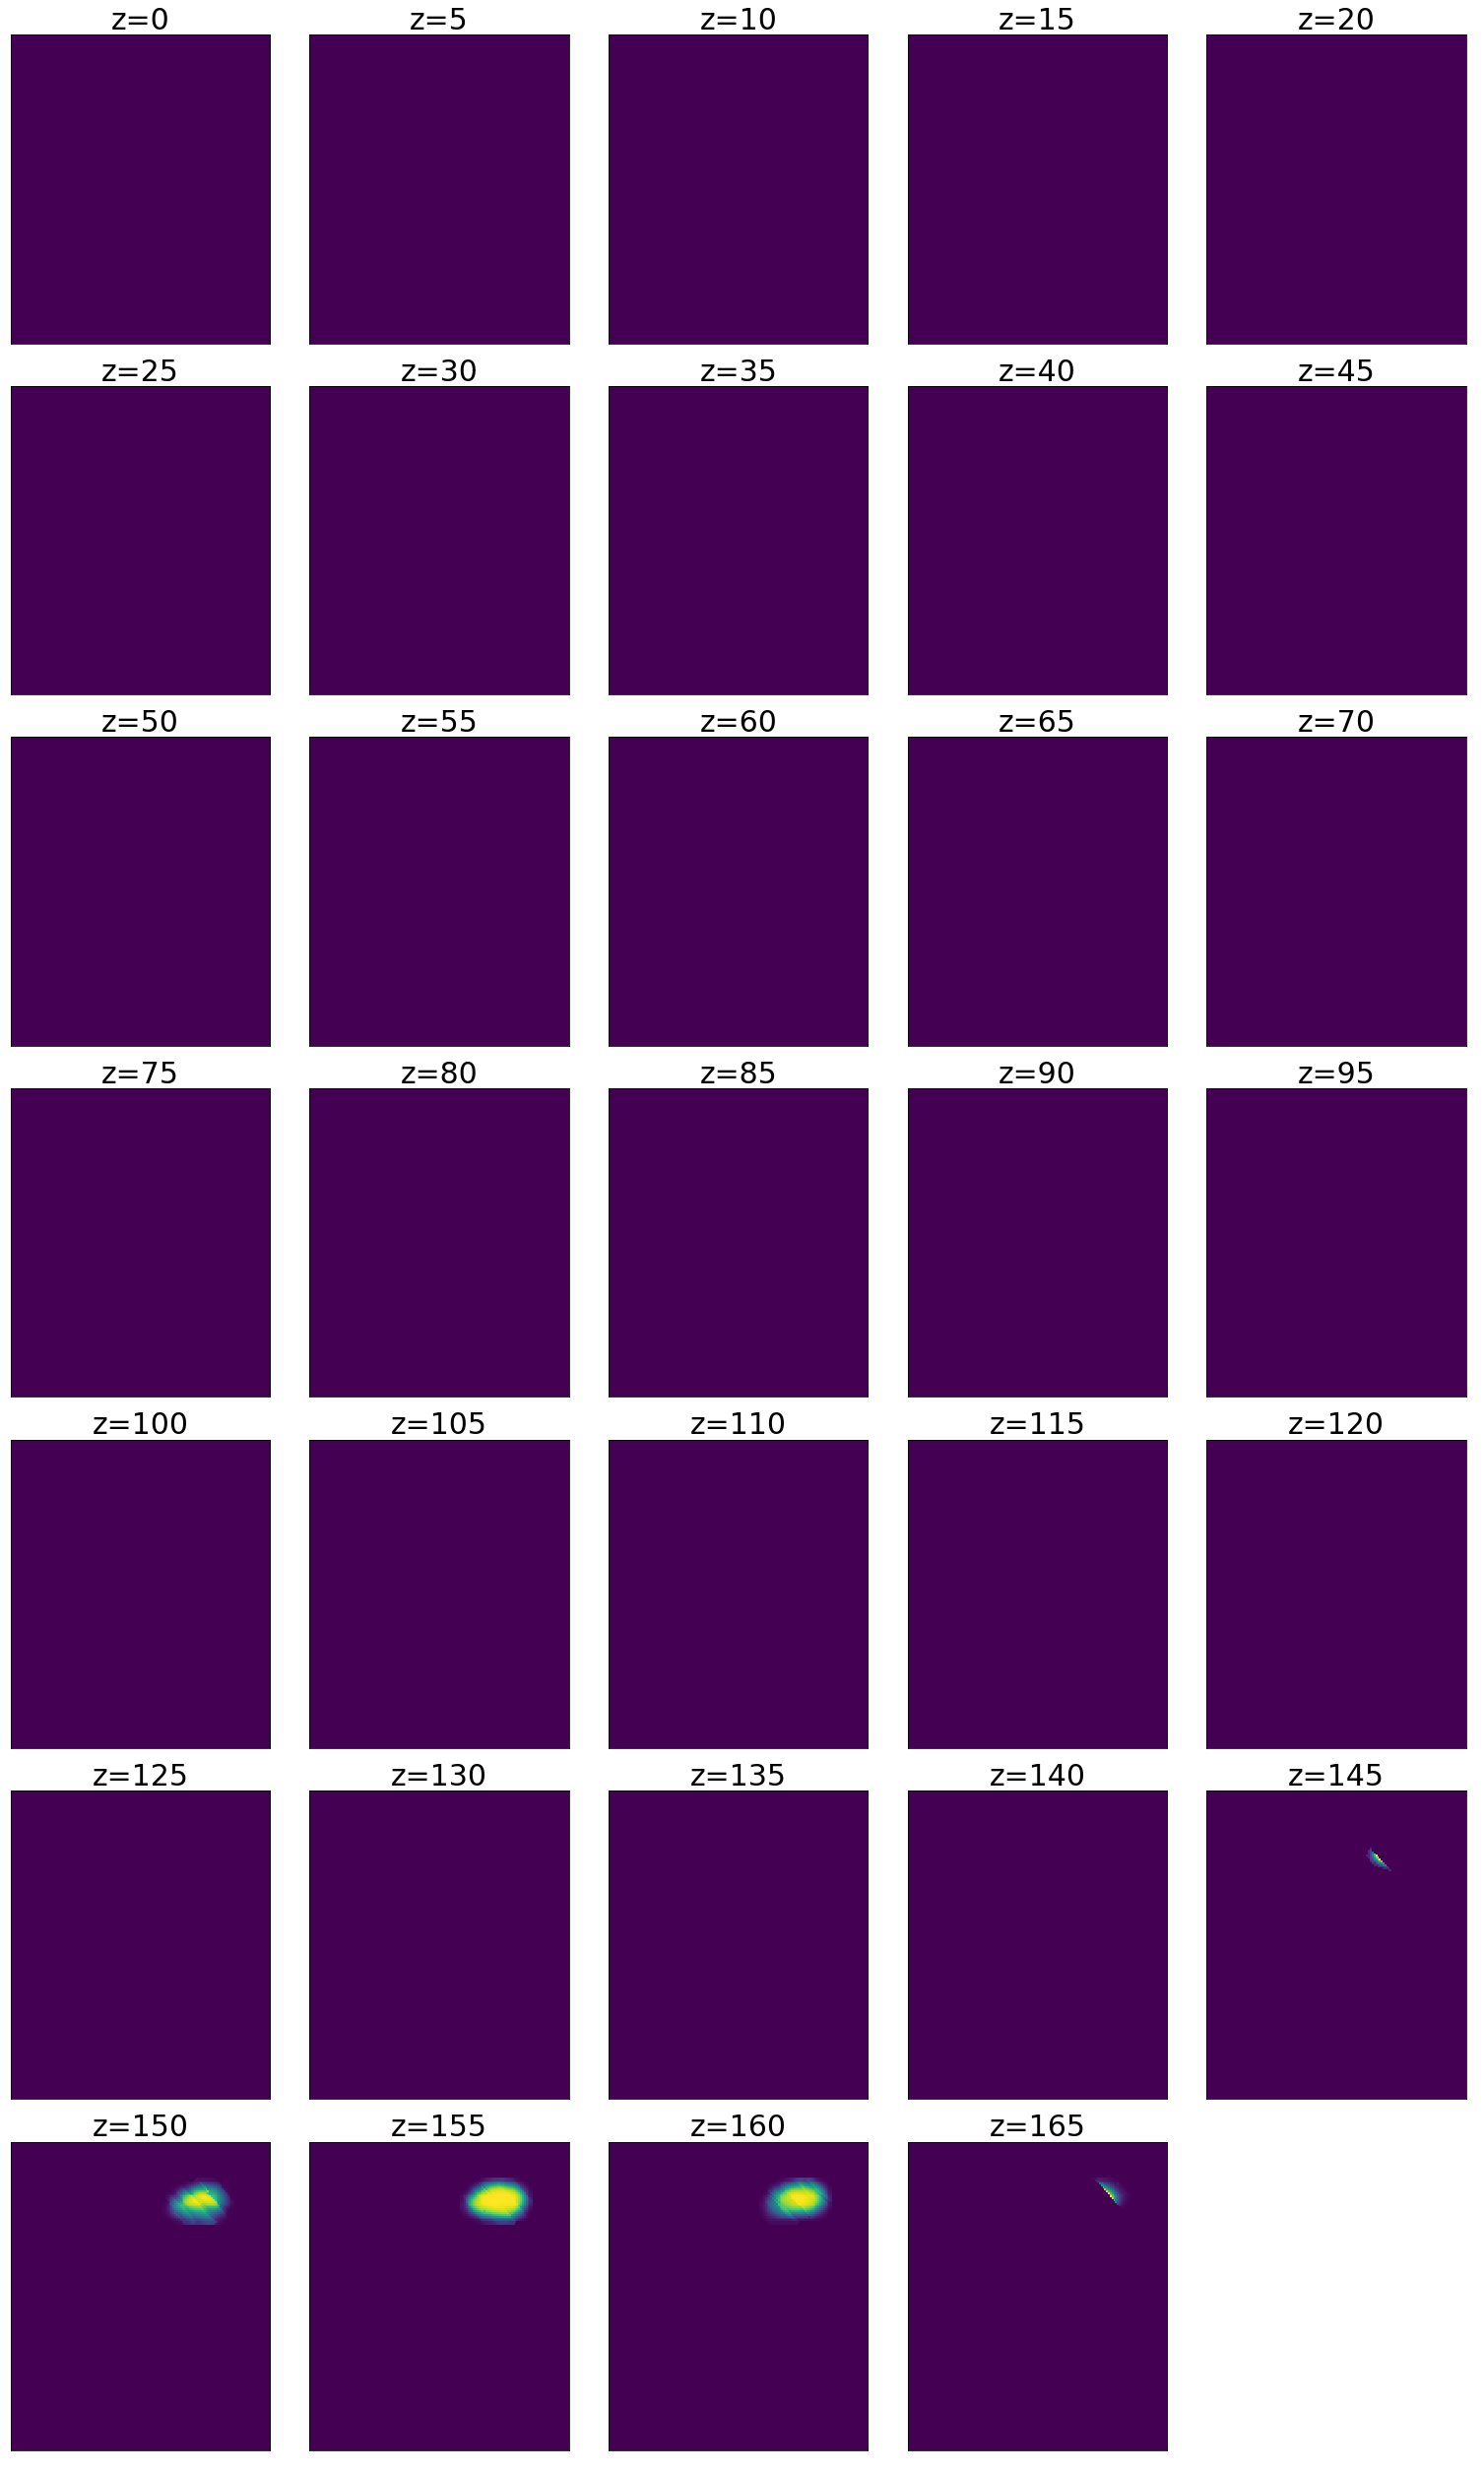

In [94]:
display_volume_sections(crop_and_pad_volume(volume_m_alignedTo_f, in_bbox=volume_m_alignedTo_f_bbox,
                                           out_bbox=(0, xdim_f-1, 0, ydim_f-1, 0, zdim_f-1)), 
                        start_level=0)

In [95]:
#########################
# Save the best trial
#########################

best_trial = np.argsort([np.max(scores) for scores in scores_all_trials])[-1]

# Save parameters
params_fp = \
    DataManager.get_alignment_result_filepath(stack_m=stack_moving, 
                                                  stack_f=stack_fixed,
                                                  warp_setting=warp_setting,
                                                 trial_idx=None, what='parameters')
DataManager.save_alignment_parameters(params_fp, T_all_trials[best_trial], 
                                      aligner.centroid_m, aligner.centroid_f,
                                      aligner.xdim_m, aligner.ydim_m, aligner.zdim_m, 
                                      aligner.xdim_f, aligner.ydim_f, aligner.zdim_f)
upload_to_s3(params_fp)

# Save score history
history_fp = DataManager.get_alignment_result_filepath(stack_m=stack_moving, 
                                              stack_f=stack_fixed,
                                              warp_setting=warp_setting,
                                             trial_idx=None, what='scoreHistory')
bp.pack_ndarray_file(np.array(scores_all_trials[best_trial]), history_fp)
upload_to_s3(history_fp)

# Save score plot
score_plot_fp = \
history_fp = DataManager.get_alignment_result_filepath(stack_m=stack_moving, 
                                              stack_f=stack_fixed,
                                              warp_setting=warp_setting,
                                             trial_idx=None, what='scoreEvolution')
fig = plt.figure();
plt.plot(scores_all_trials[best_trial]);
plt.savefig(score_plot_fp, bbox_inches='tight')
plt.close(fig)
upload_to_s3(score_plot_fp)

# Save trajectory
trajectory_fp = DataManager.get_alignment_result_filepath(stack_m=stack_moving, 
                                                  stack_f=stack_fixed,
                                                  warp_setting=warp_setting,
                                                 trial_idx=None, what='trajectory')
bp.pack_ndarray_file(np.array(traj_all_trials[best_trial]), trajectory_fp)
upload_to_s3(trajectory_fp)

aws s3 cp "/shared/CSHL_registration_parameters/atlasV5/atlasV5_down32_scoreVolume_warp16_LM30_down32_scoreVolume/atlasV5_down32_scoreVolume_warp16_LM30_down32_scoreVolume_parameters.txt" "s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV5/atlasV5_down32_scoreVolume_warp16_LM30_down32_scoreVolume/atlasV5_down32_scoreVolume_warp16_LM30_down32_scoreVolume_parameters.txt"
aws s3 cp "/shared/CSHL_registration_parameters/atlasV5/atlasV5_down32_scoreVolume_warp16_LM30_down32_scoreVolume/atlasV5_down32_scoreVolume_warp16_LM30_down32_scoreVolume_scoreHistory.bp" "s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV5/atlasV5_down32_scoreVolume_warp16_LM30_down32_scoreVolume/atlasV5_down32_scoreVolume_warp16_LM30_down32_scoreVolume_scoreHistory.bp"
aws s3 cp "/shared/CSHL_registration_parameters/atlasV5/atlasV5_down32_scoreVolume_warp16_LM30_down32_scoreVolume/atlasV5_down32_scoreVolume_warp16_LM30_down32_scoreVolume_scoreEvolution.png" "s3://mousebrainatlas-data/CSHL_regist

# Local

In [4]:
registration_settings = read_csv(REGISTRATION_SETTINGS_CSV, header=0, index_col=0)
registration_settings

,upstream_warp_id,transform_type,terminate_thresh,grad_computation_sample_number,grid_search_sample_number,std_tx_um,std_ty_um,std_tz_um,std_theta_xy_degree,surround_weight,regularization_weight,comment
warp_id,,,,,,,,,,,,
1,None,affine,0.000010,100000.0,1000.0,2000,2000,2000,30,0,NaN,NaN
2,1,rigid,0.000010,100000.0,10000.0,100,100,100,30,0,NaN,NaN
4,1,rigid,0.000001,100000.0,10000.0,100,100,100,10,0,0.000001,NaN
5,1,rigid,0.000001,100000.0,10000.0,100,100,100,30,inverse,0.000000,NaN
6,1,affine,0.000010,100000.0,10000.0,100,100,100,30,-0.5,0.000000,NaN
7,None,rigid,0.000001,100000.0,1000.0,50,50,50,10,0,NaN,NaN
8,None,rigid,0.000001,100000.0,10000.0,200,200,200,30,inverse,0.000000,align mid-sagittal planes
9,8,rigid,0.000001,100000.0,10000.0,2000,2000,2000,30,NaN,NaN,global registration given mid-sagittal planes ...
18,8,affine,0.000001,100000.0,10000.0,200,200,200,30,NaN,NaN,global registration given mid-sagittal planes ...


In [5]:
warp_setting = 22

In [6]:
warp_properties = registration_settings.loc[warp_setting]
print warp_properties

upstream_warp_setting = warp_properties['upstream_warp_id']
if upstream_warp_setting == 'None':
    upstream_warp_setting = None
else:
    upstream_warp_setting = int(upstream_warp_setting)
    
transform_type = warp_properties['transform_type']
terminate_thresh = warp_properties['terminate_thresh']
grad_computation_sample_number = warp_properties['grad_computation_sample_number']
grid_search_sample_number = warp_properties['grid_search_sample_number']
std_tx_um = warp_properties['std_tx_um']
std_ty_um = warp_properties['std_ty_um']
std_tz_um = warp_properties['std_tz_um']
std_tx = std_tx_um/(XY_PIXEL_DISTANCE_LOSSLESS*32)
std_ty = std_ty_um/(XY_PIXEL_DISTANCE_LOSSLESS*32)
std_tz = std_tz_um/(XY_PIXEL_DISTANCE_LOSSLESS*32)
std_theta_xy = np.deg2rad(warp_properties['std_theta_xy_degree'])

try:
    surround_weight = float(warp_properties['surround_weight'])
    include_surround = surround_weight != 0 and not np.isnan(surround_weight)
except:
    surround_weight = str(warp_properties['surround_weight'])
    include_surround = True

reg_weight = warp_properties['regularization_weight']
if np.isnan(reg_weight):
    reg_weights = np.zeros((3,))
else:
    reg_weights = np.ones((3,))*reg_weight

print
print 'std', std_tx, std_ty, std_tz, std_theta_xy
print 'surround', surround_weight
print 'regularization', reg_weights

upstream_warp_id                                        None
transform_type                                         rigid
terminate_thresh                                         NaN
grad_computation_sample_number                        100000
grid_search_sample_number                              10000
std_tx_um                                                200
std_ty_um                                                200
std_tz_um                                                200
std_theta_xy_degree                                       30
surround_weight                                      inverse
regularization_weight                                      0
comment                           global reg rigid with surr
Name: 22, dtype: object

std 13.5869565217 13.5869565217 13.5869565217 0.523598775598
surround inverse
regularization [ 0.  0.  0.]


In [7]:
MAX_ITER_NUM = 10000
HISTORY_LEN = 200
MAX_GRID_SEARCH_ITER_NUM = 30

In [8]:
lr1 = 10
lr2 = 0.1

In [9]:
structure = 'SNR_L'

In [10]:
if include_surround:
    volume_fixed, structure_to_label_fixed, label_to_structure_fixed = DataManager.load_original_volume_all_known_structures(stack=stack_fixed, 
                                structures=[structure, convert_to_surround_name(structure, margin='200')], volume_type='annotationAsScore')
else:
    volume_fixed, structure_to_label_fixed, label_to_structure_fixed = DataManager.load_original_volume_all_known_structures(stack=stack_fixed, 
                                                                 structures=[structure], volume_type='annotationAsScore')
# This loads the internal/inside-bbox volume.
# So registration is done with respect to this.
# Need to take into account the actual bbox when converting points.

Prior structure/index map not found. Generating a new one.
Volume shape: (170, 143, 197)


In [11]:
DataManager.load_original_volume_bbox(stack=stack_fixed, structure='SNR_L', volume_type='annotationAsScore')

array([ -19,  123,  711,  880, 1310, 1506])

In [12]:
if include_surround:
    volume_moving, structure_to_label_moving, label_to_structure_moving = DataManager.load_original_volume_all_known_structures(stack=stack_moving, 
                                structures=[structure, convert_to_surround_name(structure, margin='200')])
else:
    volume_moving, structure_to_label_moving, label_to_structure_moving = DataManager.load_original_volume_all_known_structures(stack=stack_moving, 
                                                                 structures=[structure])

# structure_to_label_moving = {s: l+1 for l, s in enumerate(sorted(volume_moving.keys()))}
# label_to_structure_moving = {l+1: s for l, s in enumerate(sorted(volume_moving.keys()))}
# volume_moving = {structure_to_label_moving[s]: v for s, v in volume_moving.items()}

label_mapping_m2f = {label_m: structure_to_label_fixed[name_m] 
                     for label_m, name_m in label_to_structure_moving.iteritems()}

cutoff = .5 # Structure size is defined as the number of voxels whose value is above this cutoff probability.
pool = Pool(NUM_CORES)
volume_moving_structure_sizes = dict(zip(volume_moving.keys(), 
                                         pool.map(lambda l: np.count_nonzero(volume_moving[l] > cutoff), 
                                                  volume_moving.keys())))
pool.close()
pool.join()


positive_weight = 'size'
# positive_weight = 'inverse'

label_weights_m = {}

for label_m in label_mapping_m2f.iterkeys():
    name_m = label_to_structure_moving[label_m]
    if not is_surround_label(name_m):
        if positive_weight == 'size':
            label_weights_m[label_m] = 1.
        elif positive_weight == 'inverse':
            p = np.percentile(volume_moving_structure_sizes.values(), 50)
            label_weights_m[label_m] =  np.minimum(p / volume_moving_structure_sizes[label_m], 1.)
        else:
            sys.stderr.write("positive_weight %s is not recognized. Using the default.\n" % positive_weight)
            
for label_m in label_mapping_m2f.iterkeys():
    name_m = label_to_structure_moving[label_m]
    if is_surround_label(name_m):
        label_ns = structure_to_label_moving[convert_to_nonsurround_name(name_m)]
        if surround_weight == 'inverse':
#             label_weights_m[label_m] = - label_weights_m[label_ns] * volume_moving_structure_sizes[label_ns]/float(volume_moving_structure_sizes[label_m])
            label_weights_m[label_m] = label_weights_m[label_ns] * volume_moving_structure_sizes[label_ns]/float(volume_moving_structure_sizes[label_m])
        elif isinstance(surround_weight, int) or isinstance(surround_weight, float):
            label_weights_m[label_m] = surround_weight
        else:
            sys.stderr.write("surround_weight %s is not recognized. Using the default.\n" % surround_weight)

Prior structure/index map not found. Generating a new one.
Volume shape: (356, 427, 375)


In [13]:
label_weights_m

{1: 1.0, 2: 0.40870655618253604}

In [14]:
aligner = Aligner4(volume_fixed, volume_moving, 
                   labelIndexMap_m2f=label_mapping_m2f)

aligner.set_centroid(centroid_m='structure_centroid', centroid_f='structure_centroid', 
                     indices_m=[structure_to_label_moving[structure]])

aligner.set_regularization_weights(reg_weights)
aligner.set_label_weights(label_weights_m)

Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.
centroid_m: [  50.43135167  207.82499502   91.38163608], centroid_f: [  68.79608517  101.98764769   61.5795571 ]


In [15]:
# grid_search_T, grid_search_score = aligner.do_grid_search(grid_search_iteration_number=MAX_GRID_SEARCH_ITER_NUM, 
#                grid_search_sample_number=8,
#               std_tx=std_tx, std_ty=std_ty, std_tz=std_tz, std_theta_xy=0,
#                grid_search_eta=3., stop_radius_voxel=3)

In [16]:
gradient_filepath_map_f = \
{ind_f: DataManager.get_volume_gradient_filepath_template(\
                                                          stack=stack_fixed, 
                                                          structure=label_to_structure_fixed[ind_f],
                                                         volume_type='annotationAsScore')
 for ind_m, ind_f in label_mapping_m2f.iteritems()}

In [17]:
aligner.load_gradient(gradient_filepath_map_f=gradient_filepath_map_f) # 120s = 2 mins

indices_f: set([1, 2])


rm -rf "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volume_gradients/LM30_down32_annotationAsScoreVolume_SNR_L_gx.bp" && mkdir -p "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volume_gradients"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volume_gradients/LM30_down32_annotationAsScoreVolume_SNR_L_gx.bp" "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volume_gradients/LM30_down32_annotationAsScoreVolume_SNR_L_gx.bp"
rm -rf "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volume_gradients/LM30_down32_annotationAsScoreVolume_SNR_L_gy.bp" && mkdir -p "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volume_gradients"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volume_gradients/LM30_down32_annotationAsScoreVolume_SNR_L_gy.bp" "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreV

load gradient 1: 1.572220 seconds


rm -rf "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volume_gradients/LM30_down32_annotationAsScoreVolume_SNR_L_surround_200_gx.bp" && mkdir -p "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volume_gradients"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volume_gradients/LM30_down32_annotationAsScoreVolume_SNR_L_surround_200_gx.bp" "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volume_gradients/LM30_down32_annotationAsScoreVolume_SNR_L_surround_200_gx.bp"
rm -rf "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volume_gradients/LM30_down32_annotationAsScoreVolume_SNR_L_surround_200_gy.bp" && mkdir -p "/shared/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volume_gradients"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM30/LM30_down32_annotationAsScoreVolume/score_volume_gradients/LM30_down32_annotationAsScoreVolume_SNR_L_surround_200

load gradient 2: 1.525243 seconds
overall: 3.097736 seconds


In [18]:
trial_num = 1

T_all_trials = []
scores_all_trials = []
traj_all_trials = []

for trial_idx in range(trial_num):

    T, scores = aligner.optimize(tf_type=transform_type, 
                                 max_iter_num=MAX_ITER_NUM, 
                                 history_len=HISTORY_LEN, 
#                                  grad_computation_sample_number=int(grad_computation_sample_number),
                                 lr1=1, lr2=1e-2, 
                                 terminate_thresh_trans=0.5, terminate_thresh_rot=0.001)
#                                  init_T=grid_search_T)

#         print T.reshape((3,4))
#         plt.figure();
#         plt.plot(scores);
#         plt.show();
#         print max(scores), scores[-1]

    T_all_trials.append(T)
    scores_all_trials.append(scores)
    traj_all_trials.append(np.array(aligner.Ts))


iteration 0
sample: 0.00 s
sample: 0.00 s
step: 0.24 seconds
current score: 0.336999
new_T: [ 0.99993333  0.98996692 -1.00996642]
det: 1.00

iteration 1
sample: 0.00 s
sample: 0.00 s
step: 0.23 seconds
current score: 0.336744
new_T: [  5.99658548e-01   9.43327144e-05  -1.54896848e-01]
det: 1.00

iteration 2
sample: 0.00 s
sample: 0.00 s
step: 0.23 seconds
current score: 0.338407
new_T: [ 0.96547363 -0.1173855  -0.23499835]
det: 1.00

iteration 3
sample: 0.00 s
sample: 0.00 s
step: 0.23 seconds
current score: 0.338795
new_T: [ 0.91992727 -0.42997444 -0.0333176 ]
det: 1.00

iteration 4
sample: 0.00 s
sample: 0.00 s
step: 0.23 seconds
current score: 0.339069
new_T: [ 1.14750317 -0.41623586 -0.16002192]
det: 1.00

iteration 5
sample: 0.00 s
sample: 0.00 s
step: 0.24 seconds
current score: 0.339523
new_T: [  1.04841429e+00  -6.76548701e-01  -6.27679832e-04]
det: 1.00

iteration 6
sample: 0.00 s
sample: 0.00 s
step: 0.23 seconds
current score: 0.339836
new_T: [ 1.07945566 -0.77321047 -0.033

sample: 0.00 s
step: 0.23 seconds
current score: 0.342599
new_T: [-0.3138957  -2.54529122 -0.02445866]
det: 1.00

iteration 59
sample: 0.00 s
sample: 0.00 s
step: 0.23 seconds
current score: 0.342628
new_T: [-0.32758085 -2.53638934 -0.02279225]
det: 1.00

iteration 60
sample: 0.00 s
sample: 0.00 s
step: 0.23 seconds
current score: 0.342614
new_T: [ -3.39276659e-01  -2.55755112e+00  -1.13836838e-03]
det: 1.00

iteration 61
sample: 0.00 s
sample: 0.00 s
step: 0.23 seconds
current score: 0.342615
new_T: [-0.35877262 -2.54801438 -0.01390147]
det: 1.00

iteration 62
sample: 0.00 s
sample: 0.00 s
step: 0.23 seconds
current score: 0.342618
new_T: [ -3.84369165e-01  -2.56098859e+00  -2.50560670e-03]
det: 1.00

iteration 63
sample: 0.00 s
sample: 0.00 s
step: 0.23 seconds
current score: 0.342626
new_T: [-0.37893233 -2.56343717 -0.00486568]
det: 1.00

iteration 64
sample: 0.00 s
sample: 0.00 s
step: 0.23 seconds
current score: 0.342616
new_T: [ -3.93459002e-01  -2.57970852e+00   2.05842490e-03]


sample: 0.00 s
step: 0.23 seconds
current score: 0.342523
new_T: [-0.38808152 -2.87749877  0.12551563]
det: 1.00

iteration 117
sample: 0.00 s
sample: 0.00 s
step: 0.23 seconds
current score: 0.342528
new_T: [-0.39813277 -2.87754508  0.1280645 ]
det: 1.00

iteration 118
sample: 0.00 s
sample: 0.00 s
step: 0.23 seconds
current score: 0.342521
new_T: [-0.40325379 -2.88162781  0.11524253]
det: 1.00

iteration 119
sample: 0.00 s
sample: 0.00 s
step: 0.23 seconds
current score: 0.342518
new_T: [-0.41408203 -2.88839956  0.11230888]
det: 1.00

iteration 120
sample: 0.00 s
sample: 0.00 s
step: 0.24 seconds
current score: 0.342512
new_T: [-0.40441867 -2.8912079   0.11266722]
det: 1.00

iteration 121
sample: 0.00 s
sample: 0.00 s
step: 0.24 seconds
current score: 0.342512
new_T: [-0.41175483 -2.90115635  0.10856638]
det: 1.00

iteration 122
sample: 0.00 s
sample: 0.00 s
step: 0.24 seconds
current score: 0.342492
new_T: [-0.40171065 -2.89186902  0.10491515]
det: 1.00

iteration 123
sample: 0.00 s

sample: 0.00 s
step: 0.23 seconds
current score: 0.342477
new_T: [-0.42616059 -2.91454233  0.17514166]
det: 1.00

iteration 175
sample: 0.00 s
sample: 0.00 s
step: 0.23 seconds
current score: 0.342473
new_T: [-0.43033224 -2.90679373  0.17156683]
det: 1.00

iteration 176
sample: 0.00 s
sample: 0.00 s
step: 0.23 seconds
current score: 0.342460
new_T: [-0.41210362 -2.9092901   0.17466061]
det: 1.00

iteration 177
sample: 0.00 s
sample: 0.00 s
step: 0.23 seconds
current score: 0.342488
new_T: [-0.43084028 -2.91318293  0.17673352]
det: 1.00

iteration 178
sample: 0.00 s
sample: 0.00 s
step: 0.24 seconds
current score: 0.342463
new_T: [-0.40213893 -2.90690835  0.17735464]
det: 1.00

iteration 179
sample: 0.00 s
sample: 0.00 s
step: 0.24 seconds
current score: 0.342499
new_T: [-0.42035018 -2.90871847  0.17875747]
det: 1.00

iteration 180
sample: 0.00 s
sample: 0.00 s
step: 0.24 seconds
current score: 0.342475
new_T: [-0.42605728 -2.90935233  0.18256166]
det: 1.00

iteration 181
sample: 0.00 s

sample: 0.00 s
step: 0.24 seconds
current score: 0.342435
new_T: [-0.41965461 -2.95418142  0.22881836]
det: 1.00

iteration 233
sample: 0.00 s
sample: 0.00 s
step: 0.23 seconds
current score: 0.342487
new_T: [-0.3584458  -2.91303608  0.19509225]
det: 1.00

iteration 234
sample: 0.00 s
sample: 0.00 s
step: 0.23 seconds
current score: 0.342426
new_T: [-0.3944227  -2.94145726  0.21751062]
det: 1.00

iteration 235
sample: 0.00 s
sample: 0.00 s
step: 0.23 seconds
current score: 0.342440
new_T: [-0.35029284 -2.92222021  0.19520855]
det: 1.00

iteration 236
sample: 0.00 s
sample: 0.00 s
step: 0.23 seconds
current score: 0.342429
new_T: [-0.41066239 -2.948646    0.23055743]
det: 1.00

iteration 237
sample: 0.00 s
sample: 0.00 s
step: 0.23 seconds
current score: 0.342466
new_T: [-0.33106321 -2.9140341   0.20159112]
det: 1.00

iteration 238
sample: 0.00 s
sample: 0.00 s
step: 0.24 seconds
current score: 0.342472
new_T: [-0.38166818 -2.9498001   0.23119948]
det: 1.00

iteration 239
sample: 0.00 s

sample: 0.00 s
step: 0.23 seconds
current score: 0.342402
new_T: [-0.33858745 -2.94494411  0.21491606]
det: 1.00

iteration 291
sample: 0.00 s
sample: 0.00 s
step: 0.23 seconds
current score: 0.342416
new_T: [-0.34010712 -2.94163442  0.21107569]
det: 1.00

iteration 292
sample: 0.00 s
sample: 0.00 s
step: 0.23 seconds
current score: 0.342402
new_T: [-0.33670982 -2.94017141  0.21104538]
det: 1.00

iteration 293
sample: 0.00 s
sample: 0.00 s
step: 0.23 seconds
current score: 0.342407
new_T: [-0.33759994 -2.94339268  0.21175569]
det: 1.00

iteration 294
sample: 0.00 s
sample: 0.00 s
step: 0.24 seconds
current score: 0.342400
new_T: [-0.33546577 -2.94469619  0.21296015]
det: 1.00

iteration 295
sample: 0.00 s
sample: 0.00 s
step: 0.23 seconds
current score: 0.342403
new_T: [-0.33730496 -2.94487961  0.21454741]
det: 1.00

iteration 296
sample: 0.00 s
sample: 0.00 s
step: 0.23 seconds
current score: 0.342404
new_T: [-0.33872459 -2.94150976  0.21724007]
det: 1.00

iteration 297
sample: 0.00 s

sample: 0.00 s
step: 0.24 seconds
current score: 0.342413
new_T: [-0.34381232 -2.95264248  0.22994105]
det: 1.00

iteration 349
sample: 0.00 s
sample: 0.00 s
step: 0.24 seconds
current score: 0.342419
new_T: [-0.33871825 -2.95617393  0.22998716]
det: 1.00

iteration 350
sample: 0.00 s
sample: 0.00 s
step: 0.24 seconds
current score: 0.342416
new_T: [-0.32640014 -2.94535182  0.22574581]
det: 1.00

iteration 351
sample: 0.00 s
sample: 0.00 s
step: 0.24 seconds
current score: 0.342413
new_T: [-0.33268445 -2.95130705  0.22670185]
det: 1.00

iteration 352
sample: 0.00 s
sample: 0.00 s
step: 0.23 seconds
current score: 0.342420
new_T: [-0.34032073 -2.94532147  0.22613506]
det: 1.00

iteration 353
sample: 0.00 s
sample: 0.00 s
step: 0.23 seconds
current score: 0.342413
new_T: [-0.34232327 -2.94826506  0.23004605]
det: 1.00

iteration 354
sample: 0.00 s
sample: 0.00 s
step: 0.24 seconds
current score: 0.342419
new_T: [-0.33774466 -2.94689511  0.23465249]
det: 1.00

iteration 355
sample: 0.00 s

sample: 0.00 s
step: 0.23 seconds
current score: 0.342381
new_T: [-0.37793405 -2.93600579  0.23089952]
det: 1.00

iteration 407
sample: 0.00 s
sample: 0.00 s
step: 0.24 seconds
current score: 0.342373
new_T: [-0.36959062 -2.93005262  0.22714151]
det: 1.00

iteration 408
sample: 0.00 s
sample: 0.00 s
step: 0.23 seconds
current score: 0.342369
new_T: [-0.38556189 -2.93366029  0.23466795]
det: 1.00

iteration 409
sample: 0.00 s
sample: 0.00 s
step: 0.23 seconds
current score: 0.342370
new_T: [-0.36239703 -2.91914507  0.22498283]
det: 1.00

iteration 410
sample: 0.00 s
sample: 0.00 s
step: 0.24 seconds
current score: 0.342378
new_T: [-0.38625781 -2.94508708  0.23205304]
det: 1.00

iteration 411
sample: 0.00 s
sample: 0.00 s
step: 0.23 seconds
current score: 0.342369
new_T: [-0.3600908  -2.92915683  0.22016246]
det: 1.00

iteration 412
sample: 0.00 s
sample: 0.00 s
step: 0.23 seconds
current score: 0.342390
new_T: [-0.37439851 -2.93644738  0.23028956]
det: 1.00

iteration 413
sample: 0.00 s

sample: 0.00 s
step: 0.23 seconds
current score: 0.342374
new_T: [-0.39055869 -2.94179016  0.22833611]
det: 1.00

iteration 465
sample: 0.00 s
sample: 0.00 s
step: 0.23 seconds
current score: 0.342376
new_T: [-0.3453428  -2.91746183  0.20683591]
det: 1.00

iteration 466
sample: 0.00 s
sample: 0.00 s
step: 0.23 seconds
current score: 0.342426
new_T: [-0.36176147 -2.94496655  0.22512401]
det: 1.00

iteration 467
sample: 0.00 s
sample: 0.00 s
step: 0.23 seconds
current score: 0.342380
new_T: [-0.37780954 -2.94191973  0.22750881]
det: 1.00

iteration 468
sample: 0.00 s
sample: 0.00 s
step: 0.23 seconds
current score: 0.342346
new_T: [-0.36874641 -2.93387086  0.21899539]
det: 1.00

iteration 469
sample: 0.00 s
sample: 0.00 s
step: 0.23 seconds
current score: 0.342366
new_T: [-0.39152211 -2.94287728  0.22402878]
det: 1.00

iteration 470
sample: 0.00 s
sample: 0.00 s
step: 0.23 seconds
current score: 0.342372
new_T: [-0.34462394 -2.91908545  0.20243266]
det: 1.00

iteration 471
sample: 0.00 s

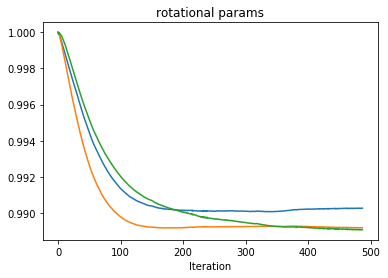

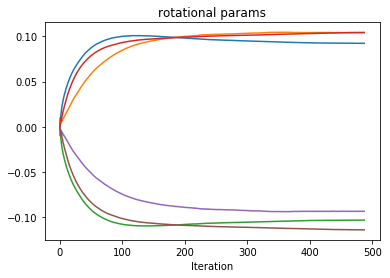

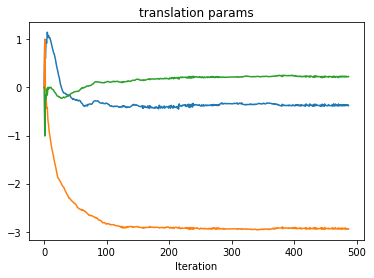

In [19]:
Ts = np.array(aligner.Ts)

plt.plot(Ts[:, [0,5,10]]);
plt.title('rotational params');
plt.xlabel('Iteration');
plt.show();

plt.plot(Ts[:, [1,2,4,6,8,9]]);
plt.title('rotational params');
plt.xlabel('Iteration');
plt.show();

plt.plot(Ts[:, [3,7,11]]);
plt.title('translation params');
plt.xlabel('Iteration');
plt.show();

Best trial: 0
0.342680312118 0.342387574568
[[ 0.99222359  0.09770112  0.07711576 -0.28240478]
 [-0.10450499  0.99046439  0.08977196 -2.70113339]
 [-0.06760959 -0.09713284  0.99297238  0.11260127]]


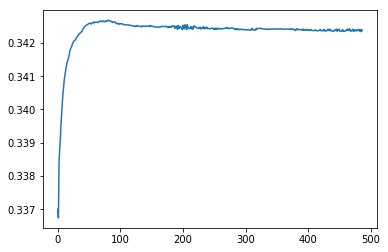

In [20]:
best_trial = np.argsort([np.max(scores) for scores in scores_all_trials])[-1]
# best_trial = 1
T = T_all_trials[best_trial]
scores = scores_all_trials[best_trial]
print 'Best trial:', best_trial
print max(scores), scores[-1]

print T.reshape((3,4))
plt.figure();
plt.plot(scores);
plt.show();

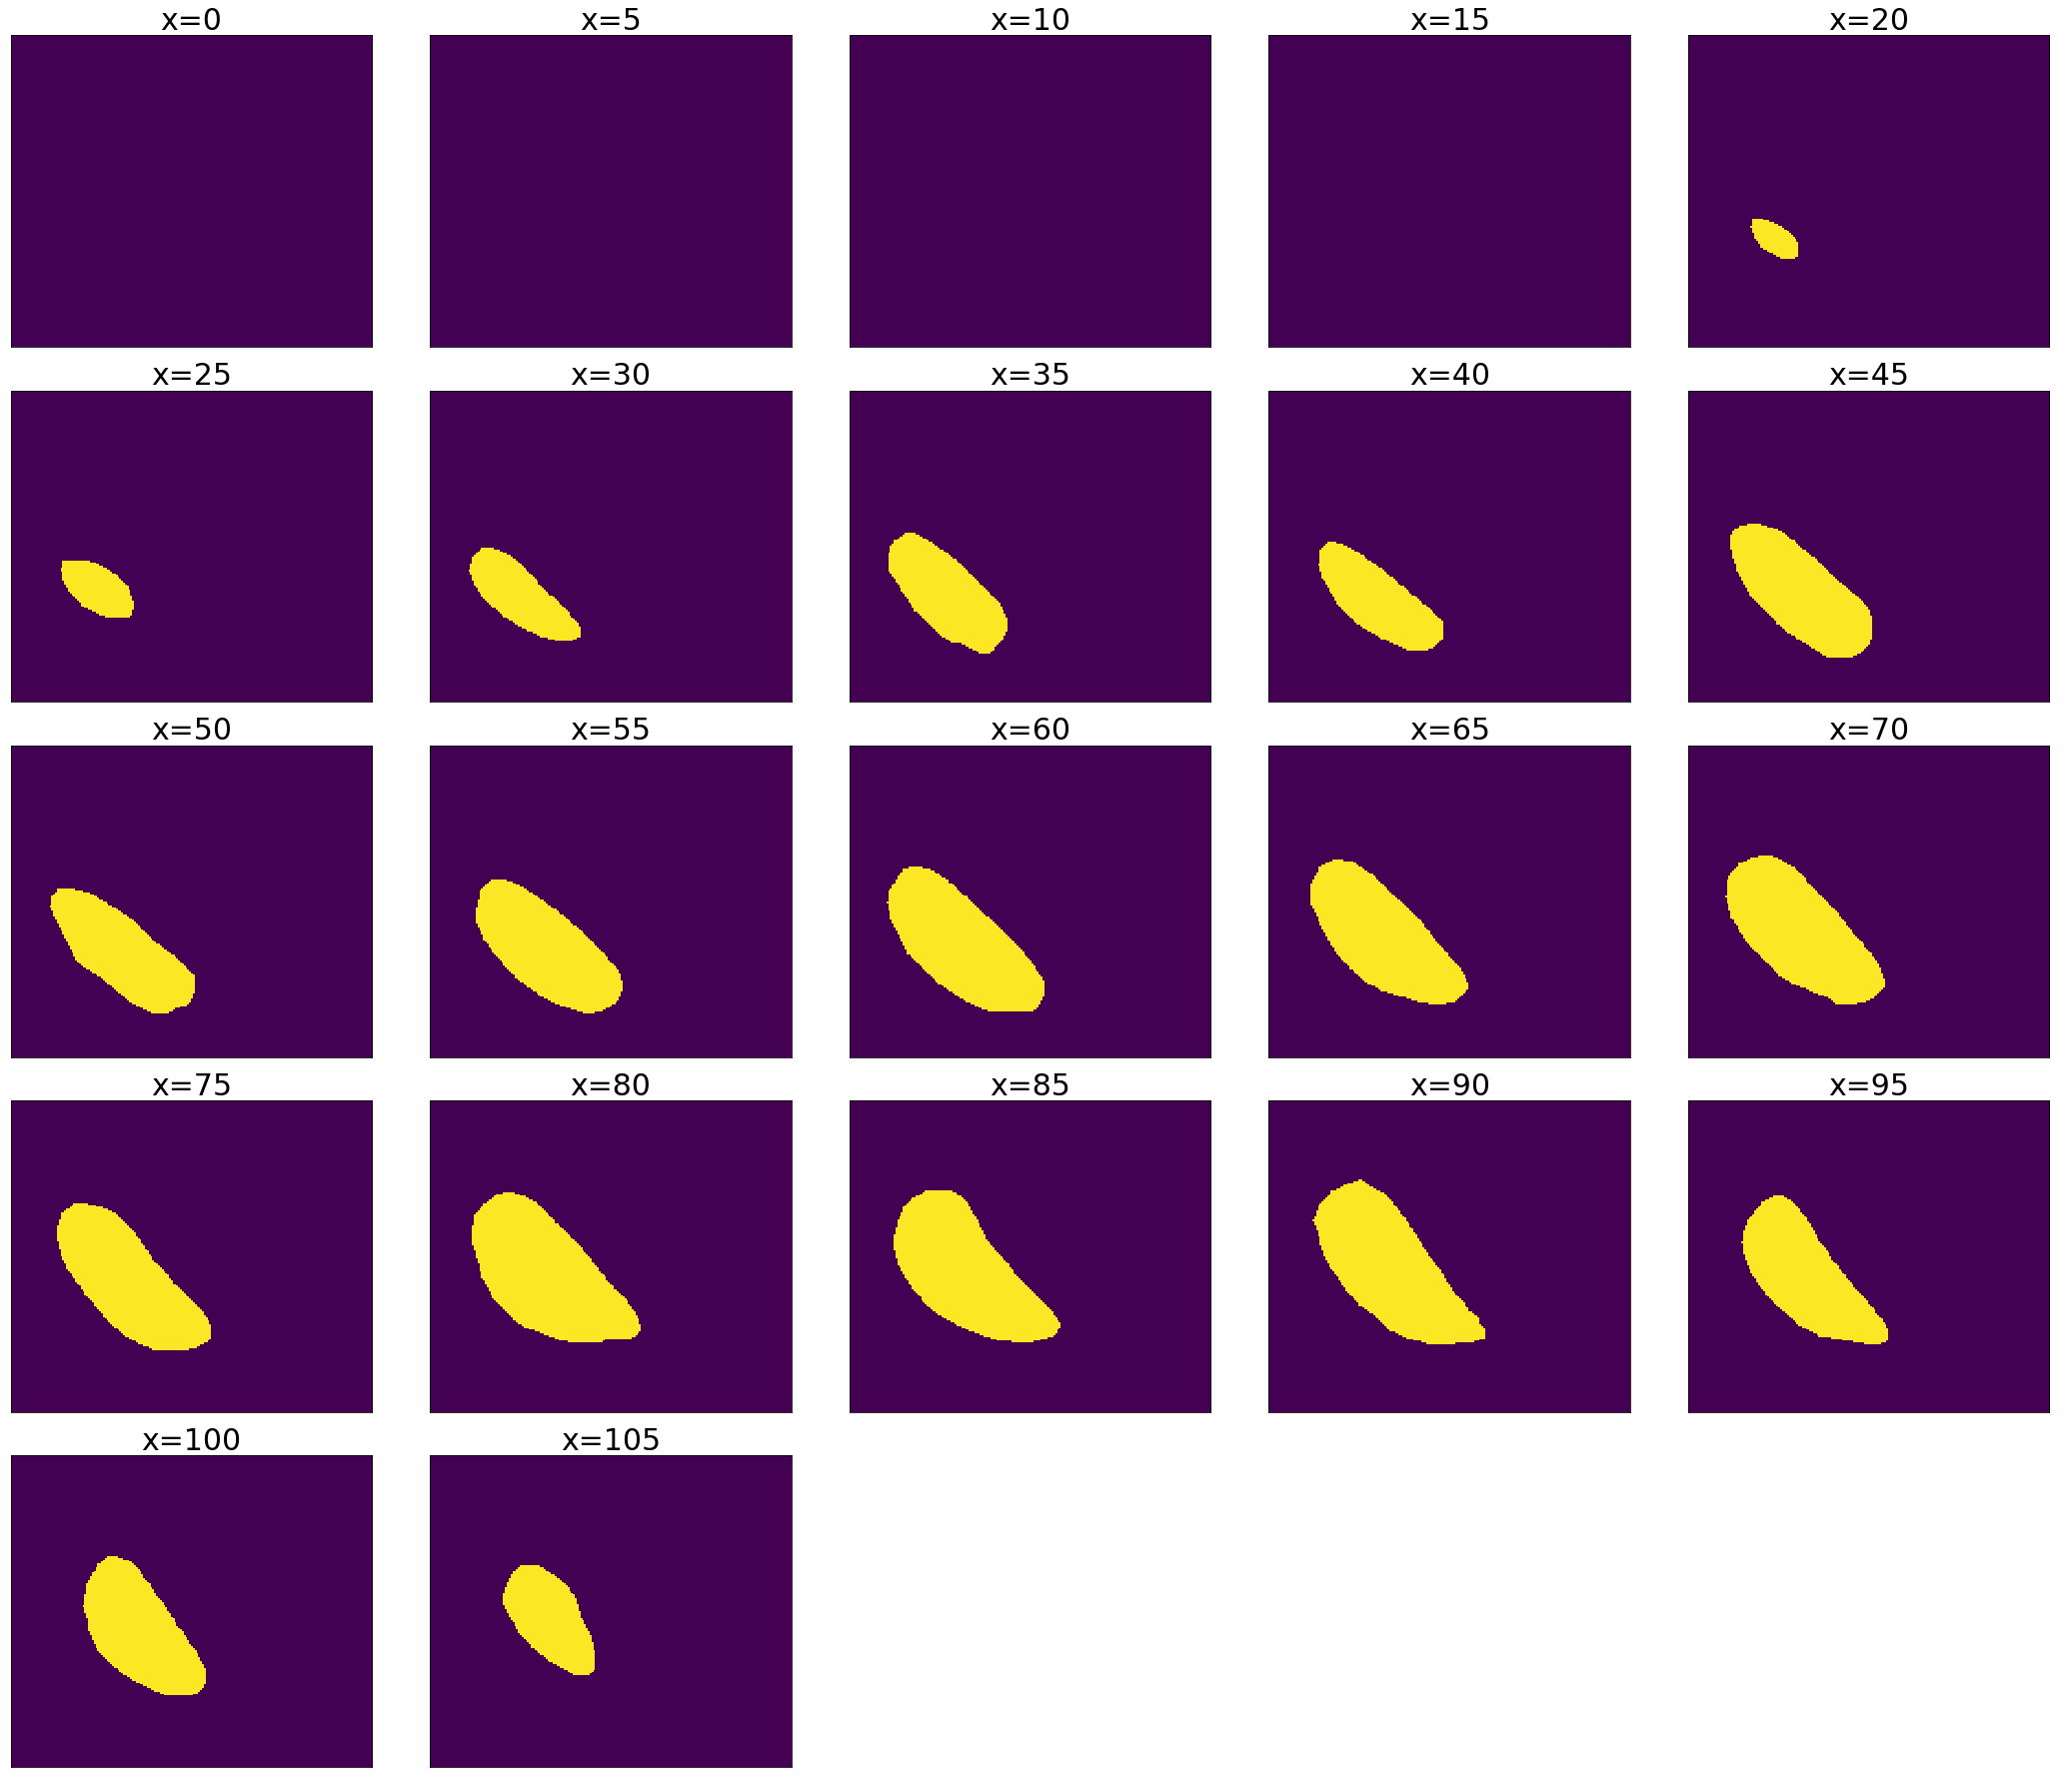

In [21]:
display_volume_sections(volume_fixed[structure_to_label_fixed[structure]], start_level=0, every=5, direction='x')

In [22]:
local_params, centroid_m, centroid_f, xdim_m, ydim_m, zdim_m, xdim_f, ydim_f, zdim_f = \
(T, 
  aligner.centroid_m, aligner.centroid_f,
  aligner.xdim_m, aligner.ydim_m, aligner.zdim_m, 
  aligner.xdim_f, aligner.ydim_f, aligner.zdim_f)

# local_params, centroid_m, centroid_f, xdim_m, ydim_m, zdim_m, xdim_f, ydim_f, zdim_f = \
# ([1,0,0,0,0,1,0,0,0,0,1,0], 
#   aligner.centroid_m, aligner.centroid_f,
#   aligner.xdim_m, aligner.ydim_m, aligner.zdim_m, 
#   aligner.xdim_f, aligner.ydim_f, aligner.zdim_f)

In [23]:
# Transform moving volume, sided, without surround

# structure = '3N_L'

# vol_m = DataManager.load_original_volume(stack=stack_moving, structure=structure, downscale=32)

vol_m = volume_moving[structure_to_label_moving[structure]]

volume_m_alignedTo_f, volume_m_alignedTo_f_bbox = \
transform_volume_v2(vol=vol_m, tf_params=local_params, centroid_m=centroid_m, centroid_f=centroid_f)

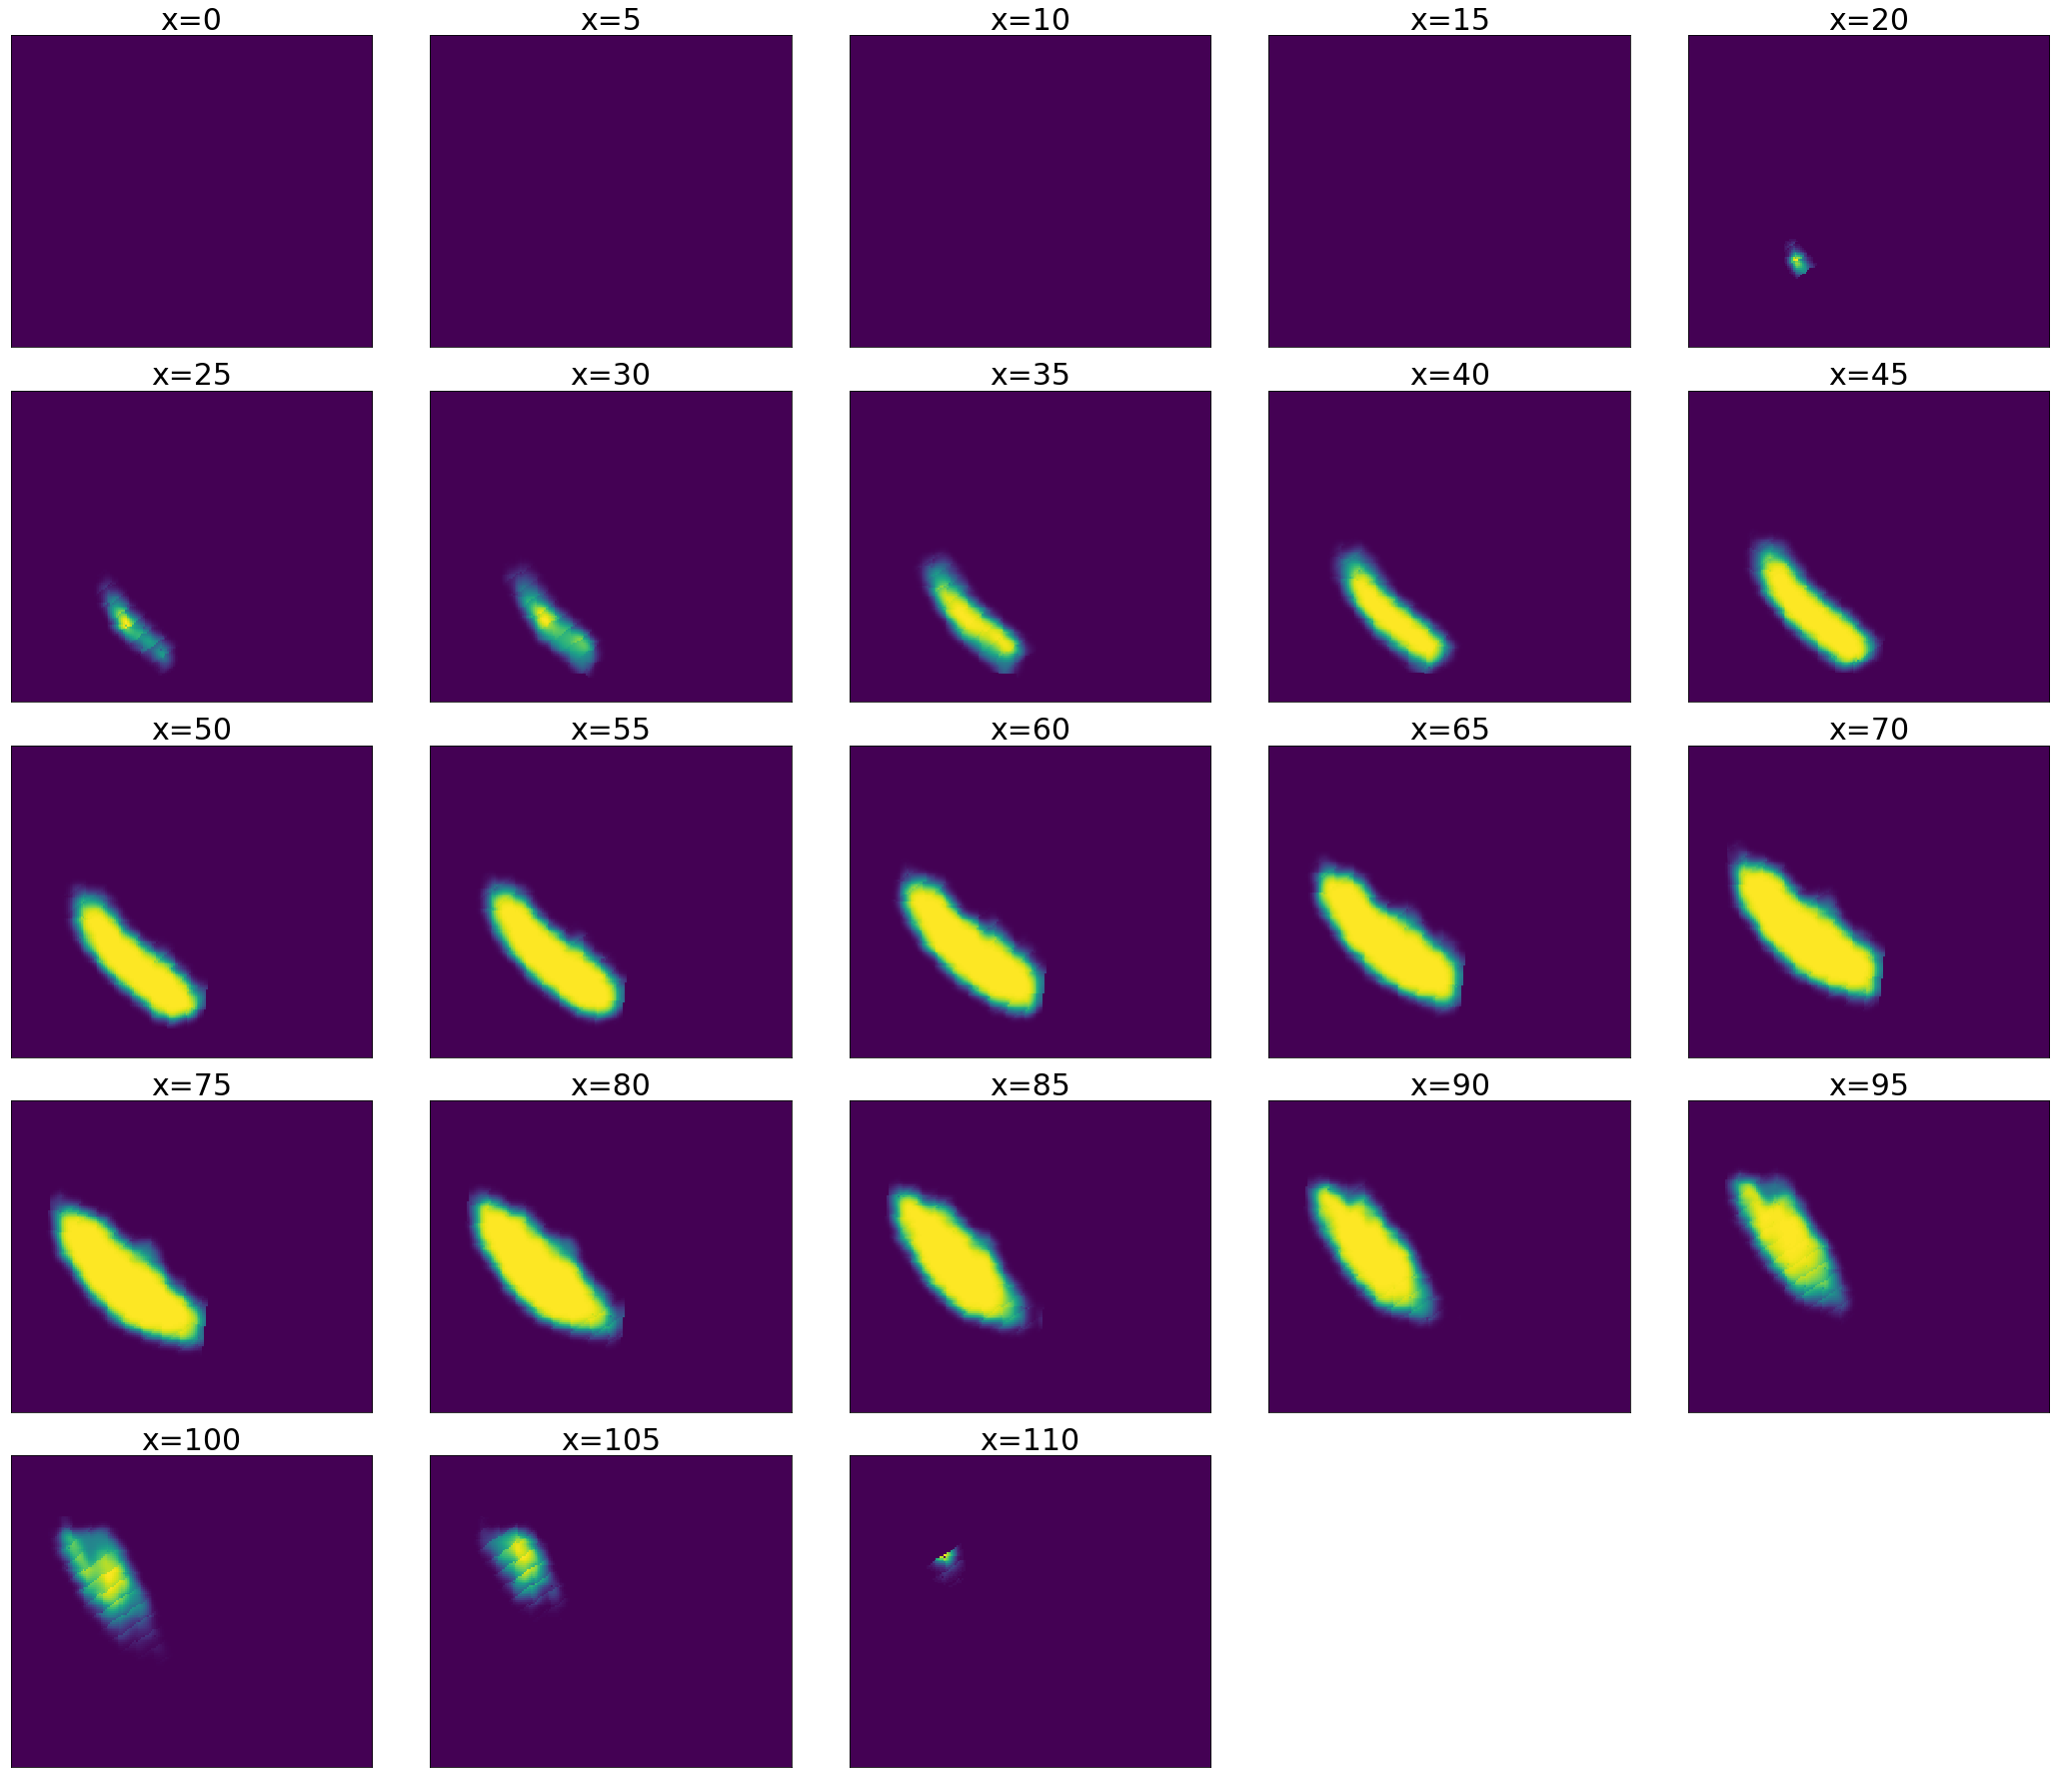

In [24]:
display_volume_sections(crop_and_pad_volume(volume_m_alignedTo_f, in_bbox=volume_m_alignedTo_f_bbox,
                                           out_bbox=(0, xdim_f-1, 0, ydim_f-1, 0, zdim_f-1)), 
                        start_level=0,
                       direction='x')

In [25]:
#########################
# Save the best trial
#########################

best_trial = np.argsort([np.max(scores) for scores in scores_all_trials])[-1]

# Save parameters
params_fp = \
    DataManager.get_alignment_result_filepath(stack_m=stack_moving, 
                                                  stack_f=stack_fixed,
                                                          structure_f=structure,
                                                          structure_m=structure,
                                                  warp_setting=warp_setting,
                                                 trial_idx=None, what='parameters')
DataManager.save_alignment_parameters(params_fp, T_all_trials[best_trial], 
                                      aligner.centroid_m, aligner.centroid_f,
                                      aligner.xdim_m, aligner.ydim_m, aligner.zdim_m, 
                                      aligner.xdim_f, aligner.ydim_f, aligner.zdim_f)
upload_to_s3(params_fp)

# Save score history
history_fp = DataManager.get_alignment_result_filepath(stack_m=stack_moving, 
                                              stack_f=stack_fixed,
                                                structure_f=structure,
                                                structure_m=structure, 
                                              warp_setting=warp_setting,
                                             trial_idx=None, what='scoreHistory')
bp.pack_ndarray_file(np.array(scores_all_trials[best_trial]), history_fp)
upload_to_s3(history_fp)

# Save score plot
score_plot_fp = \
history_fp = DataManager.get_alignment_result_filepath(stack_m=stack_moving, 
                                              stack_f=stack_fixed,
                                                structure_f=structure,
                                                structure_m=structure,
                                              warp_setting=warp_setting,
                                             trial_idx=None, what='scoreEvolution')
fig = plt.figure();
plt.plot(scores_all_trials[best_trial]);
plt.savefig(score_plot_fp, bbox_inches='tight')
plt.close(fig)
upload_to_s3(score_plot_fp)

# Save trajectory
trajectory_fp = DataManager.get_alignment_result_filepath(stack_m=stack_moving, 
                                                  stack_f=stack_fixed,
                                                structure_f=structure,
                                                structure_m=structure,
                                                  warp_setting=warp_setting,
                                                 trial_idx=None, what='trajectory')
bp.pack_ndarray_file(np.array(traj_all_trials[best_trial]), trajectory_fp)
upload_to_s3(trajectory_fp)

aws s3 cp "/shared/CSHL_registration_parameters/atlasV5/atlasV5_down32_scoreVolume_SNR_L_warp22_LM30_down32_scoreVolume_SNR_L/atlasV5_down32_scoreVolume_SNR_L_warp22_LM30_down32_scoreVolume_SNR_L_parameters.txt" "s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV5/atlasV5_down32_scoreVolume_SNR_L_warp22_LM30_down32_scoreVolume_SNR_L/atlasV5_down32_scoreVolume_SNR_L_warp22_LM30_down32_scoreVolume_SNR_L_parameters.txt"
aws s3 cp "/shared/CSHL_registration_parameters/atlasV5/atlasV5_down32_scoreVolume_SNR_L_warp22_LM30_down32_scoreVolume_SNR_L/atlasV5_down32_scoreVolume_SNR_L_warp22_LM30_down32_scoreVolume_SNR_L_scoreHistory.bp" "s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV5/atlasV5_down32_scoreVolume_SNR_L_warp22_LM30_down32_scoreVolume_SNR_L/atlasV5_down32_scoreVolume_SNR_L_warp22_LM30_down32_scoreVolume_SNR_L_scoreHistory.bp"
aws s3 cp "/shared/CSHL_registration_parameters/atlasV5/atlasV5_down32_scoreVolume_SNR_L_warp22_LM30_down32_scoreVolume_SNR_L/atlasV5_